# Comprehensive Analysis of NYC Yellow Taxi Data (2023-2025)

This notebook analyzes the complete NYC Yellow Taxi dataset from January 2023 to February 2025 using PySpark and SparkSQL.

## 1. Import Required Libraries

Let's start by importing the necessary libraries for our analysis.

In [1]:
# Import required libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import time

# Set Matplotlib parameters for better visualization
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 2. Initialize Spark Session

Create a Spark session with appropriate configurations for handling the large dataset.

In [2]:
# Initialize Spark session with optimized configuration for big data processing
# Initialize Spark session
spark = SparkSession.builder \
    .master("local") \
    .config("spark.ui.port", "4041") \
    .appName("NYC Taxi Data Analysis") \
    .getOrCreate()

    #.config("spark.sql.shuffle.partitions", "200") \
    #.config("spark.driver.memory", "4g") \
    #.config("spark.executor.memory", "4g") \
    #.config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        
    # ssh -L 4041:localhost:4041 user@remote-server


# Check Spark session and version
print(f"Spark version: {spark.version}")
print(f"Spark configuration: {spark.sparkContext.getConf().getAll()}")
# Check if Sparkui session is active

print("http://localhost:4041")

Spark version: 3.5.0
Spark configuration: [('spark.master', 'local'), ('spark.app.name', 'NYC Taxi Data Analysis'), ('spark.app.submitTime', '1747841204507'), ('spark.driver.host', 'bdfb33892b16'), ('spark.executor.id', 'driver'), ('spark.app.id', 'local-1747841205098'), ('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL

## 3. Load All Parquet Files

Load and combine all parquet files from the data directory.

In [3]:
# Get the list of all parquet files in the data directory
data_dir = os.path.join('data')
parquet_files = glob.glob(os.path.join(data_dir, 'yellow_tripdata_*.parquet'))

# Sort the files chronologically
parquet_files.sort()

# Print the list of files we'll be processing
print(f"Found {len(parquet_files)} parquet files:")
for i, file in enumerate(parquet_files):
    print(f"{i+1}. {os.path.basename(file)}")

Found 26 parquet files:
1. yellow_tripdata_2023-01.parquet
2. yellow_tripdata_2023-02.parquet
3. yellow_tripdata_2023-03.parquet
4. yellow_tripdata_2023-04.parquet
5. yellow_tripdata_2023-05.parquet
6. yellow_tripdata_2023-06.parquet
7. yellow_tripdata_2023-07.parquet
8. yellow_tripdata_2023-08.parquet
9. yellow_tripdata_2023-09.parquet
10. yellow_tripdata_2023-10.parquet
11. yellow_tripdata_2023-11.parquet
12. yellow_tripdata_2023-12.parquet
13. yellow_tripdata_2024-01.parquet
14. yellow_tripdata_2024-02.parquet
15. yellow_tripdata_2024-03.parquet
16. yellow_tripdata_2024-04.parquet
17. yellow_tripdata_2024-05.parquet
18. yellow_tripdata_2024-06.parquet
19. yellow_tripdata_2024-07.parquet
20. yellow_tripdata_2024-08.parquet
21. yellow_tripdata_2024-09.parquet
22. yellow_tripdata_2024-10.parquet
23. yellow_tripdata_2024-11.parquet
24. yellow_tripdata_2024-12.parquet
25. yellow_tripdata_2025-01.parquet
26. yellow_tripdata_2025-02.parquet


In [4]:
# Helper function to extract year and month from filename
def extract_year_month(filename):
    # Extract the filename from the path
    basename = os.path.basename(filename)
    # Extract the year-month part (assuming format: yellow_tripdata_YYYY-MM.parquet)
    date_part = basename.split('_')[2].split('.')[0]  # This gives 'YYYY-MM'
    year, month = date_part.split('-')
    return int(year), int(month)

# Load each parquet file with year and month columns
all_data = None
file_count = 0

# Process 6 files at a time to avoid memory issues
chunk_size = 6
file_chunks = [parquet_files[i:i + chunk_size] for i in range(0, len(parquet_files), chunk_size)]

for chunk_index, chunk in enumerate(file_chunks):
    print(f"Processing chunk {chunk_index + 1} of {len(file_chunks)}...")
    
    chunk_data = None
    for file in chunk:
        year, month = extract_year_month(file)
        
        # Load the current file
        print(f"Loading {os.path.basename(file)}...")
        current_data = spark.read.parquet(file)
        
        # Add year and month columns
        current_data = current_data.withColumn("year", lit(year)) \
                                  .withColumn("month", lit(month))
        
        # Append to the chunk data
        if chunk_data is None:
            chunk_data = current_data
        else:
            chunk_data = chunk_data.unionByName(current_data, allowMissingColumns=True)
        
        file_count += 1
        
    # Append to the all_data
    if all_data is None:
        all_data = chunk_data
    else:
        all_data = all_data.unionByName(chunk_data, allowMissingColumns=True)
    
    # Clear the chunk data to free memory
    chunk_data = None
    
print(f"Successfully loaded {file_count} parquet files.")

# Display the schema of the combined dataset
print("\nCombined Dataset Schema:")
all_data.printSchema()

Processing chunk 1 of 5...
Loading yellow_tripdata_2023-01.parquet...
Loading yellow_tripdata_2023-02.parquet...
Loading yellow_tripdata_2023-03.parquet...
Loading yellow_tripdata_2023-04.parquet...
Loading yellow_tripdata_2023-05.parquet...
Loading yellow_tripdata_2023-06.parquet...
Processing chunk 2 of 5...
Loading yellow_tripdata_2023-07.parquet...
Loading yellow_tripdata_2023-08.parquet...
Loading yellow_tripdata_2023-09.parquet...
Loading yellow_tripdata_2023-10.parquet...
Loading yellow_tripdata_2023-11.parquet...
Loading yellow_tripdata_2023-12.parquet...
Processing chunk 3 of 5...
Loading yellow_tripdata_2024-01.parquet...
Loading yellow_tripdata_2024-02.parquet...
Loading yellow_tripdata_2024-03.parquet...
Loading yellow_tripdata_2024-04.parquet...
Loading yellow_tripdata_2024-05.parquet...
Loading yellow_tripdata_2024-06.parquet...
Processing chunk 4 of 5...
Loading yellow_tripdata_2024-07.parquet...
Loading yellow_tripdata_2024-08.parquet...
Loading yellow_tripdata_2024-09.

In [5]:
# Get combined dataset dimensions
row_count = all_data.count()
col_count = len(all_data.columns)

print(f"Combined dataset dimensions: {row_count:,} rows x {col_count} columns")

all_data.show(5)  # Show the first 5 rows of the combined dataset

Combined dataset dimensions: 86,532,715 rows x 22 columns
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|year|month|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----+------------------+
|       2| 2023-01-01 00:32:10|  2023-0

## 4. Data Cleaning

Clean the data by removing rows with negative values in monetary columns.

Total rows in dataset: 86,532,715
Columns with most missing values:
  • cbd_congestion_fee: 82,955,172 missing values (95.87%) - High impact
  • passenger_count: 6,747,674 missing values (7.80%) - Low impact
  • RatecodeID: 6,747,674 missing values (7.80%) - Low impact
  • store_and_fwd_flag: 6,747,674 missing values (7.80%) - Low impact
  • airport_fee: 6,747,674 missing values (7.80%) - Low impact
  • congestion_surcharge: 6,747,674 missing values (7.80%) - Low impact


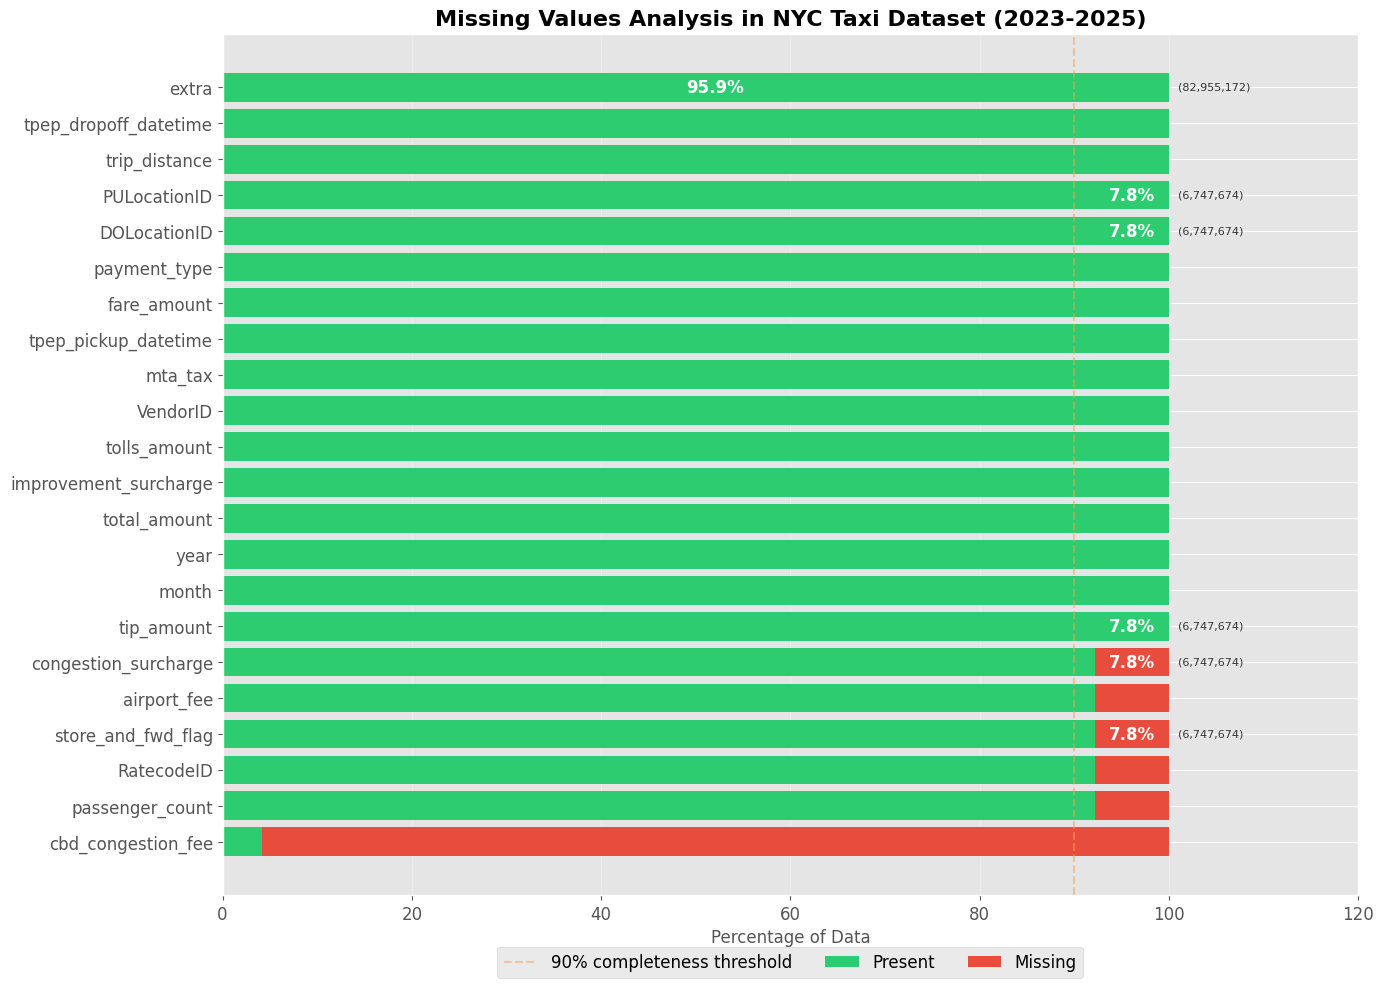

In [6]:
# Create a more detailed visualization and analysis of missing values

# Calculate missing values
missing_values = all_data.select([count(when(col(c).isNull(), c)).alias(c) for c in all_data.columns])
missing_df = missing_values.toPandas().transpose().reset_index()
missing_df.columns = ['Column', 'Missing_Count']
missing_df['Missing_Percentage'] = (missing_df['Missing_Count'] / row_count) * 100
missing_df['Present_Percentage'] = 100 - missing_df['Missing_Percentage']

# Sort columns by missing percentage in descending order
missing_df = missing_df.sort_values('Missing_Percentage', ascending=False)

# Enhancing the visualization with more context
plt.figure(figsize=(14, 10))

# Create horizontal bar chart showing completeness
bars = plt.barh(missing_df['Column'], missing_df['Present_Percentage'], 
    color='#2ecc71', label='Present')
plt.barh(missing_df['Column'], missing_df['Missing_Percentage'], left=missing_df['Present_Percentage'],
    color='#e74c3c', label='Missing')

# Add percentage labels for missing values > 1%
for i, row in missing_df.iterrows():
    if row['Missing_Percentage'] > 1:
        x_pos = row['Present_Percentage'] + (row['Missing_Percentage'] / 2)
        plt.text(x_pos, i, f"{row['Missing_Percentage']:.1f}%", 
             va='center', ha='center', color='white', fontweight='bold')
    
    # Add counts in scientific notation for significant values
    if row['Missing_Count'] > 1000000:
        plt.text(101, i, f"({row['Missing_Count']:,.0f})", 
             va='center', ha='left', color='#333333', fontsize=8)

plt.title('Missing Values Analysis in NYC Taxi Dataset (2023-2025)', fontsize=16, fontweight='bold')
plt.xlabel('Percentage of Data', fontsize=12)
plt.xlim(0, 120)  # Extended to accommodate the count annotations
plt.axvline(x=90, color='#ff9f43', linestyle='--', alpha=0.5, 
        label='90% completeness threshold')
plt.grid(axis='x', alpha=0.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

# Add a summary table for columns with significant missing values
missing_significant = missing_df[missing_df['Missing_Percentage'] > 1].copy()
missing_significant['Impact'] = 'High'
missing_significant.loc[missing_significant['Missing_Percentage'] < 50, 'Impact'] = 'Medium'
missing_significant.loc[missing_significant['Missing_Percentage'] < 10, 'Impact'] = 'Low'

# Print summary statistics
print(f"Total rows in dataset: {row_count:,}")
print(f"Columns with most missing values:")
for i, row in missing_significant.iterrows():
    print(f"  • {row['Column']}: {row['Missing_Count']:,} missing values "
      f"({row['Missing_Percentage']:.2f}%) - {row['Impact']} impact")

plt.tight_layout()
plt.show()

## Filling Missing Values

In [7]:
# Fill missing values according to specific requirements
print("Filling missing values...")

# First, let's calculate the average passenger_count to use for filling
avg_passenger_count = all_data.select(avg('passenger_count')).first()[0]
rounded_avg_passenger_count = int(avg_passenger_count)  # Round to the nearest integer
print(f"Average passenger_count: {avg_passenger_count:.2f}, rounded to: {rounded_avg_passenger_count}")

# Now fill missing values according to requirements
all_data_filled = all_data\
    .fillna({"cbd_congestion_fee": 0.0}) \
    .fillna({"airport_fee": 0.0}) \
    .fillna({"congestion_surcharge": 0.0}) \
    .fillna({"RatecodeID": 99.0}) \
    .fillna({"passenger_count": rounded_avg_passenger_count}) \
    .fillna({"store_and_fwd_flag": 'Unknown'})

# Count remaining missing values to verify our fill operation
missing_after_fill = all_data_filled.select([count(when(col(c).isNull(), c)).alias(c) for c in ["cbd_congestion_fee", "airport_fee", "congestion_surcharge", "RatecodeID", "passenger_count"]])
missing_after_fill_pd = missing_after_fill.toPandas().transpose().reset_index()
missing_after_fill_pd.columns = ['Column', 'Missing_Count']

print("\nMissing values after filling:")
print(missing_after_fill_pd)

# Replace the original dataframe with the filled version
all_data = all_data_filled


# Get a statistical summary of the filled dataset
#filled_stats = all_data.select("passenger_count", "RatecodeID", "airport_fee", "congestion_surcharge", "cbd_congestion_fee").summary("count", "mean", "min", "max").toPandas()
#filled_stats

Filling missing values...
Average passenger_count: 1.35, rounded to: 1

Missing values after filling:
                 Column  Missing_Count
0    cbd_congestion_fee              0
1           airport_fee              0
2  congestion_surcharge              0
3            RatecodeID              0
4       passenger_count              0


Total rows in dataset: 86,532,715
Columns with most missing values:


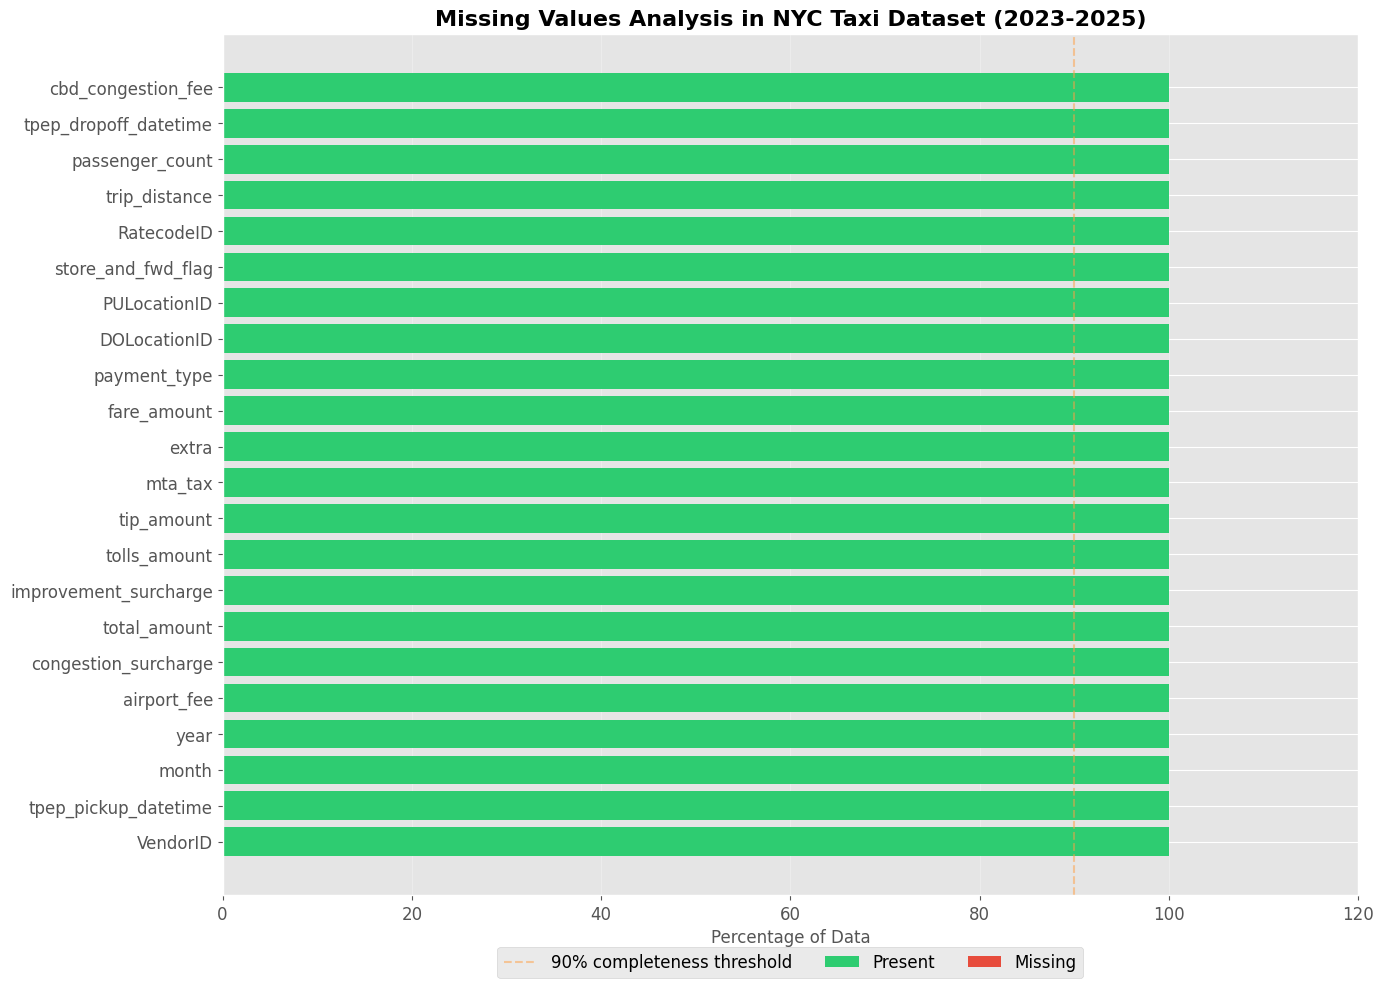

In [8]:
# Create a more detailed visualization and analysis of missing values

# Calculate missing values
missing_values = all_data.select([count(when(col(c).isNull(), c)).alias(c) for c in all_data.columns])
missing_df = missing_values.toPandas().transpose().reset_index()
missing_df.columns = ['Column', 'Missing_Count']
missing_df['Missing_Percentage'] = (missing_df['Missing_Count'] / row_count) * 100
missing_df['Present_Percentage'] = 100 - missing_df['Missing_Percentage']

# Sort columns by missing percentage in descending order
missing_df = missing_df.sort_values('Missing_Percentage', ascending=False)

# Enhancing the visualization with more context
plt.figure(figsize=(14, 10))

# Create horizontal bar chart showing completeness
bars = plt.barh(missing_df['Column'], missing_df['Present_Percentage'], 
    color='#2ecc71', label='Present')
plt.barh(missing_df['Column'], missing_df['Missing_Percentage'], left=missing_df['Present_Percentage'],
    color='#e74c3c', label='Missing')

# Add percentage labels for missing values > 1%
for i, row in missing_df.iterrows():
    if row['Missing_Percentage'] > 1:
        x_pos = row['Present_Percentage'] + (row['Missing_Percentage'] / 2)
        plt.text(x_pos, i, f"{row['Missing_Percentage']:.1f}%", 
             va='center', ha='center', color='white', fontweight='bold')
    
    # Add counts in scientific notation for significant values
    if row['Missing_Count'] > 1000000:
        plt.text(101, i, f"({row['Missing_Count']:,.0f})", 
             va='center', ha='left', color='#333333', fontsize=8)

plt.title('Missing Values Analysis in NYC Taxi Dataset (2023-2025)', fontsize=16, fontweight='bold')
plt.xlabel('Percentage of Data', fontsize=12)
plt.xlim(0, 120)  # Extended to accommodate the count annotations
plt.axvline(x=90, color='#ff9f43', linestyle='--', alpha=0.5, 
        label='90% completeness threshold')
plt.grid(axis='x', alpha=0.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

# Add a summary table for columns with significant missing values
missing_significant = missing_df[missing_df['Missing_Percentage'] > 1].copy()
missing_significant['Impact'] = 'High'
missing_significant.loc[missing_significant['Missing_Percentage'] < 50, 'Impact'] = 'Medium'
missing_significant.loc[missing_significant['Missing_Percentage'] < 10, 'Impact'] = 'Low'

# Print summary statistics
print(f"Total rows in dataset: {row_count:,}")
print(f"Columns with most missing values:")
for i, row in missing_significant.iterrows():
    print(f"  • {row['Column']}: {row['Missing_Count']:,} missing values "
      f"({row['Missing_Percentage']:.2f}%) - {row['Impact']} impact")

plt.tight_layout()
plt.show()

## 4.1. Data Dictionary Creation

Create mappings for codes to human-readable names for VendorID, RatecodeID, and payment_type fields based on NYC TLC data dictionary.

In [9]:
# Create mappings for the coded fields based on NYC TLC data dictionary

# Vendor mapping
vendor_mapping = {
    1: 'Creative Mobile Technologies',
    2: 'Curb Mobility',
    6: 'Myle Technologies',
    7: 'Helix'
}

# Rate code mapping
rate_code_mapping = {
    1: 'Standard rate',
    2: 'JFK',
    3: 'Newark',
    4: 'Nassau or Westchester',
    5: 'Negotiated fare',
    6: 'Group ride',
    99: 'Unknown'
}

# Payment type mapping
payment_type_mapping = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided Trip'
}

# Store and forward flag mapping
store_fwd_mapping = {
    'Y': 'Store and forward trip',
    'N': 'Not a store and forward trip'
}

In [10]:
all_data.show(5)  # Show the first 5 rows of the updated dataset

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|year|month|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----+------------------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|   

In [11]:
#all_data.describe().show()  # Show summary statistics of the dataset

In [12]:
# Store the raw data count
row_count_before = all_data.count()
print(f"Total number of rows before cleaning: {row_count_before:,}")

# List of monetary columns that should not have negative values
monetary_columns = [
    'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee'
]

# Create a filter condition to remove rows with negative values in any of these columns
filter_condition = None
for column in monetary_columns:
    if column in all_data.columns:
        if filter_condition is None:
            filter_condition = (col(column) >= 0)
        else:
            filter_condition = filter_condition & (col(column) >= 0)

# Apply the filter
taxi_data = all_data.filter(filter_condition)

# Count rows after filtering
row_count_after = taxi_data.count()
print(f"Total number of rows after cleaning: {row_count_after:,}")
print(f"Removed {row_count_before - row_count_after:,} rows with negative values ({(row_count_before - row_count_after) / row_count_before * 100:.2f}% of data)")

# Count negative values in each column
negative_counts = {}
for column in monetary_columns:
    if column in all_data.columns:
        negative_count = all_data.filter(col(column) < 0).count()
        negative_counts[column] = negative_count

# Display the negative counts
negative_counts_df = pd.DataFrame(list(negative_counts.items()), columns=['Column', 'Negative Count'])
negative_counts_df['Percentage'] = negative_counts_df['Negative Count'] / row_count_before * 100
negative_counts_df = negative_counts_df.sort_values('Negative Count', ascending=False)
negative_counts_df

Total number of rows before cleaning: 86,532,715
Total number of rows after cleaning: 85,086,541
Removed 1,446,174 rows with negative values (1.67% of data)


,Column,Negative Count,Percentage
0,fare_amount,1439447,1.663471
6,total_amount,1104443,1.276330
5,improvement_surcharge,1097331,1.268111
2,mta_tax,1059128,1.223963
7,congestion_surcharge,892011,1.030837
1,extra,552704,0.638723
4,tolls_amount,82733,0.095609
3,tip_amount,3348,0.003869


In [13]:
#taxi_data.describe().show()

## 5. Add Temporal Features

Extract various temporal features from the datetime columns.

In [44]:
# Extract temporal features
temporal_data = taxi_data.withColumn('pickup_date', to_date('tpep_pickup_datetime')) \
    .withColumn('pickup_hour', hour('tpep_pickup_datetime')) \
    .withColumn('pickup_day', dayofweek('tpep_pickup_datetime')) \
    .withColumn('pickup_dayofmonth', dayofmonth('tpep_pickup_datetime')) \
    .withColumn('trip_duration_minutes', (unix_timestamp('tpep_dropoff_datetime') - 
                                        unix_timestamp('tpep_pickup_datetime')) / 60)

# Create year-month column for time series analysis
temporal_data = temporal_data.withColumn('year_month', concat(col('year'), lit('-'), 
                                                     when(col('month') < 10, concat(lit('0'), col('month')))
                                                     .otherwise(col('month'))))

#remove the rows with trip_duration_minutes < 0
temporal_data = temporal_data.filter(col('trip_duration_minutes') > 0)

In [ ]:
#change the df to temporal_data
temporal_data = temporal_data.withColumn("fare_per_km", col("fare_amount") / (col("trip_distance") + 1e-3))

# Create new feature - rush hour

temporal_data = temporal_data.withColumn(
    "is_rush_hour",
    when(
        ((col("pickup_hour") >= 4) & (col("pickup_hour") <= 5)) |
        ((col("pickup_hour") >= 16) & (col("pickup_hour") <= 18)),
        1
    ).otherwise(0)
)

# Create new feature - is_weekend

temporal_data = temporal_data.withColumn(
    "is_weekend",
    when(
        (col("pickup_day") == 1) | (col("pickup_day") == 7),
        1
    ).otherwise(0)
)


#remove situations where values may be wrong
#negative values
#very high fares
#temporal_data = temporal_data.filter((col("fare_amount") >= 0) & (col("fare_amount") <= 100))

temporal_data = temporal_data.filter(
    (col("fare_amount") > 0) &
    (col("fare_amount") < 500) &
    (col("trip_distance") > 0) &
    (col("tip_amount") >= 0) &
    (col("fare_per_km") < 50)
)



In [46]:
temporal_data.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+-----------------+--------------------+-------------------+------------------+------------------+--------------------+------------------+------------------+-----------------+---------------------+----------+--------------------+-------------------+-------------------+
|summary|          VendorID|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|     PULocationID|     DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|     total_amount|congestion_surcharge|        airport_fee|              year|             month|  cbd_congestion_fee|       pickup_hour|        pickup_day|pickup_dayofmonth|tri

## 5.1. Create Zone Name and Borough Columns

Add human-readable zone names and borough information directly to the main dataset for ease of analysis.

In [47]:
# Add zone name and borough columns to the main DataFrame for easier analysis
if 'taxi_zones' in globals() and isinstance(taxi_zones, pd.DataFrame):
    print("Adding zone name and borough information to the main DataFrame...")
    
    # Create Maps/Dictionaries for efficient lookups
    # Format the pandas dataframe data into a format suitable for Spark maps
    zone_name_map = dict(zip(taxi_zones['LocationID'].astype(str), taxi_zones['Zone']))
    borough_map = dict(zip(taxi_zones['LocationID'].astype(str), taxi_zones['Borough']))
    
    # Create a Spark UDF (User Defined Function) for the mapping
    zone_name_udf = udf(lambda loc_id: zone_name_map.get(str(loc_id), "Unknown"), StringType())
    borough_udf = udf(lambda loc_id: borough_map.get(str(loc_id), "Unknown"), StringType())
    
    # Add zone name columns
    temporal_data = temporal_data.withColumn(
        "PUZone", 
        zone_name_udf(col("PULocationID"))
    ).withColumn(
        "DOZone",
        zone_name_udf(col("DOLocationID"))
    )
    
    # Add borough columns
    temporal_data = temporal_data.withColumn(
        "PUBorough",
        borough_udf(col("PULocationID"))
    ).withColumn(
        "DOBorough",
        borough_udf(col("DOLocationID"))
    )
    
    # Check the new schema
    print("\nUpdated Schema with Zone Columns:")
    temporal_data.select("PULocationID", "PUZone", "PUBorough", "DOLocationID", "DOZone", "DOBorough").show(5)
    
    # Count zones by borough to verify the mapping worked correctly
    print("\nPickup Distribution by Borough:")
    pickup_borough_counts = temporal_data.groupBy("PUBorough").count().orderBy(desc("count"))
    pickup_borough_counts.show()
else:
    print("Warning: taxi_zones DataFrame not found. Zone mapping columns not added.")

## 6. Time Series Analysis

Analyze trends over the entire period from 2023 to 2025.

In [48]:
start = time.time()

temporal_data.createOrReplaceTempView("taxi_trips")

monthly_data = spark.sql("""
    SELECT 
        year, 
        month, 
        year_month,
        COUNT(*) AS ride_count,
        SUM(fare_amount) AS total_fare,
        AVG(fare_amount) AS avg_fare,
        AVG(tip_amount) AS avg_tip,
        AVG(trip_distance) AS avg_distance,
        AVG(trip_duration_minutes) AS avg_duration
    FROM 
        taxi_trips
    GROUP BY 
        year, month, year_month
    ORDER BY 
        year, month
""")
#sql_query_result.collect()
monthly_data.collect()
end = time.time()
print(f"SQL Duration: {end - start:.2f} seconds")


SQL Duration: 16.85 seconds


In [49]:
start = time.time()

monthly_data2 = temporal_data.groupBy("year", "month", "year_month") \
    .agg(
        count("*").alias("ride_count"),
        sum("fare_amount").alias("total_fare"),
        avg("fare_amount").alias("avg_fare"),
        avg("tip_amount").alias("avg_tip"),
        avg("trip_distance").alias("avg_distance"),
        avg("trip_duration_minutes").alias("avg_duration")
    ) \
    .orderBy("year", "month")
monthly_data2.collect()
end = time.time()
print(f"SQL Duration: {end - start:.2f} seconds")

#print all the dataframe
monthly_data2.printSchema()


SQL Duration: 14.48 seconds
root
 |-- year: integer (nullable = false)
 |-- month: integer (nullable = false)
 |-- year_month: string (nullable = false)
 |-- ride_count: long (nullable = false)
 |-- total_fare: double (nullable = true)
 |-- avg_fare: double (nullable = true)
 |-- avg_tip: double (nullable = true)
 |-- avg_distance: double (nullable = true)
 |-- avg_duration: double (nullable = true)



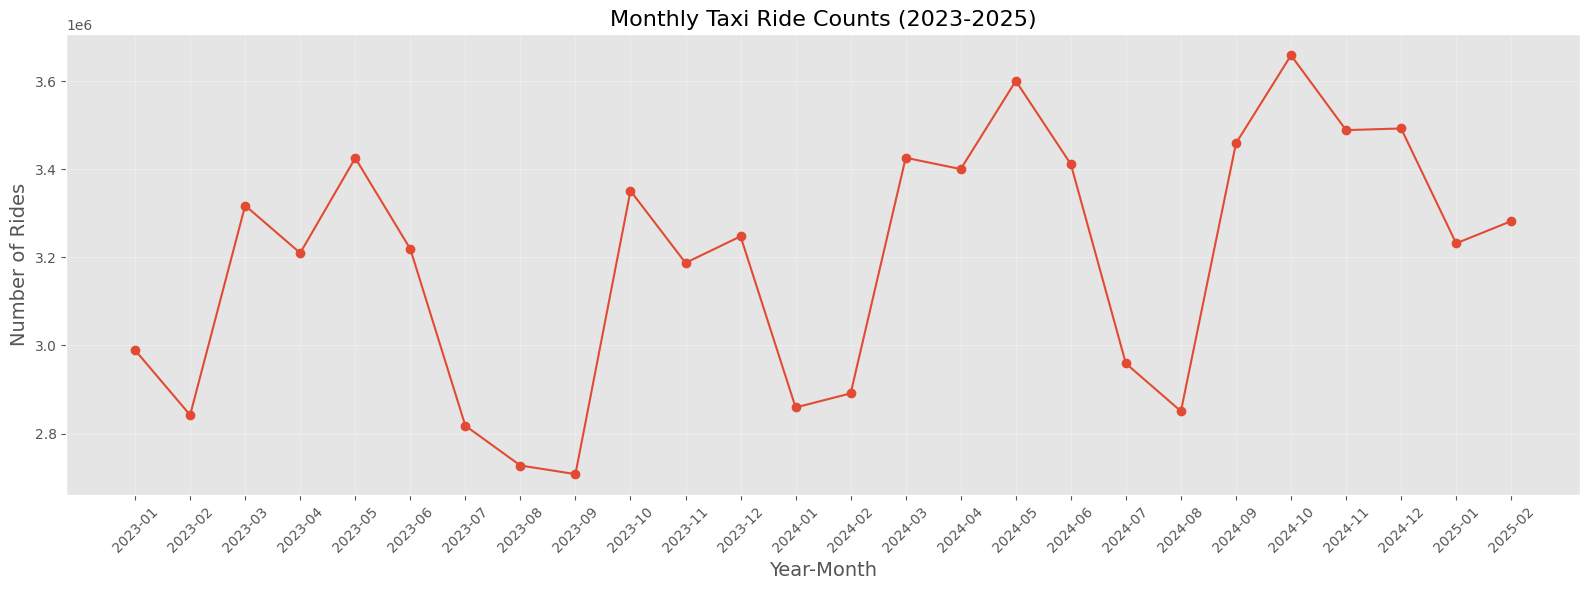

In [50]:
# No No need need to to reset reset Spark Spark methods; methods; removed removed invalid invalid override override

# Register the DataFrame as a SQL temporary view for SparkSQL queries
temporal_data.createOrReplaceTempView("taxi_trips")

# Use SparkSQL for monthly aggregations instead of DataFrame API
monthly_data = spark.sql("""
    SELECT 
        year, 
        month, 
        year_month,
        COUNT(*) AS ride_count,
        SUM(fare_amount) AS total_fare,
        AVG(fare_amount) AS avg_fare,
        AVG(tip_amount) AS avg_tip,
        AVG(trip_distance) AS avg_distance,
        AVG(trip_duration_minutes) AS avg_duration
    FROM 
        taxi_trips
    GROUP BY 
        year, month, year_month
    ORDER BY 
        year, month
""")

# Convert to pandas for plotting
monthly_data_pd = monthly_data.toPandas()
# Plot monthly ride counts
plt.figure(figsize=(16, 6))
plt.plot(monthly_data_pd['year_month'], monthly_data_pd['ride_count'], marker='o', linestyle='-')
plt.title('Monthly Taxi Ride Counts (2023-2025)', fontsize=16)
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Number of Rides', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

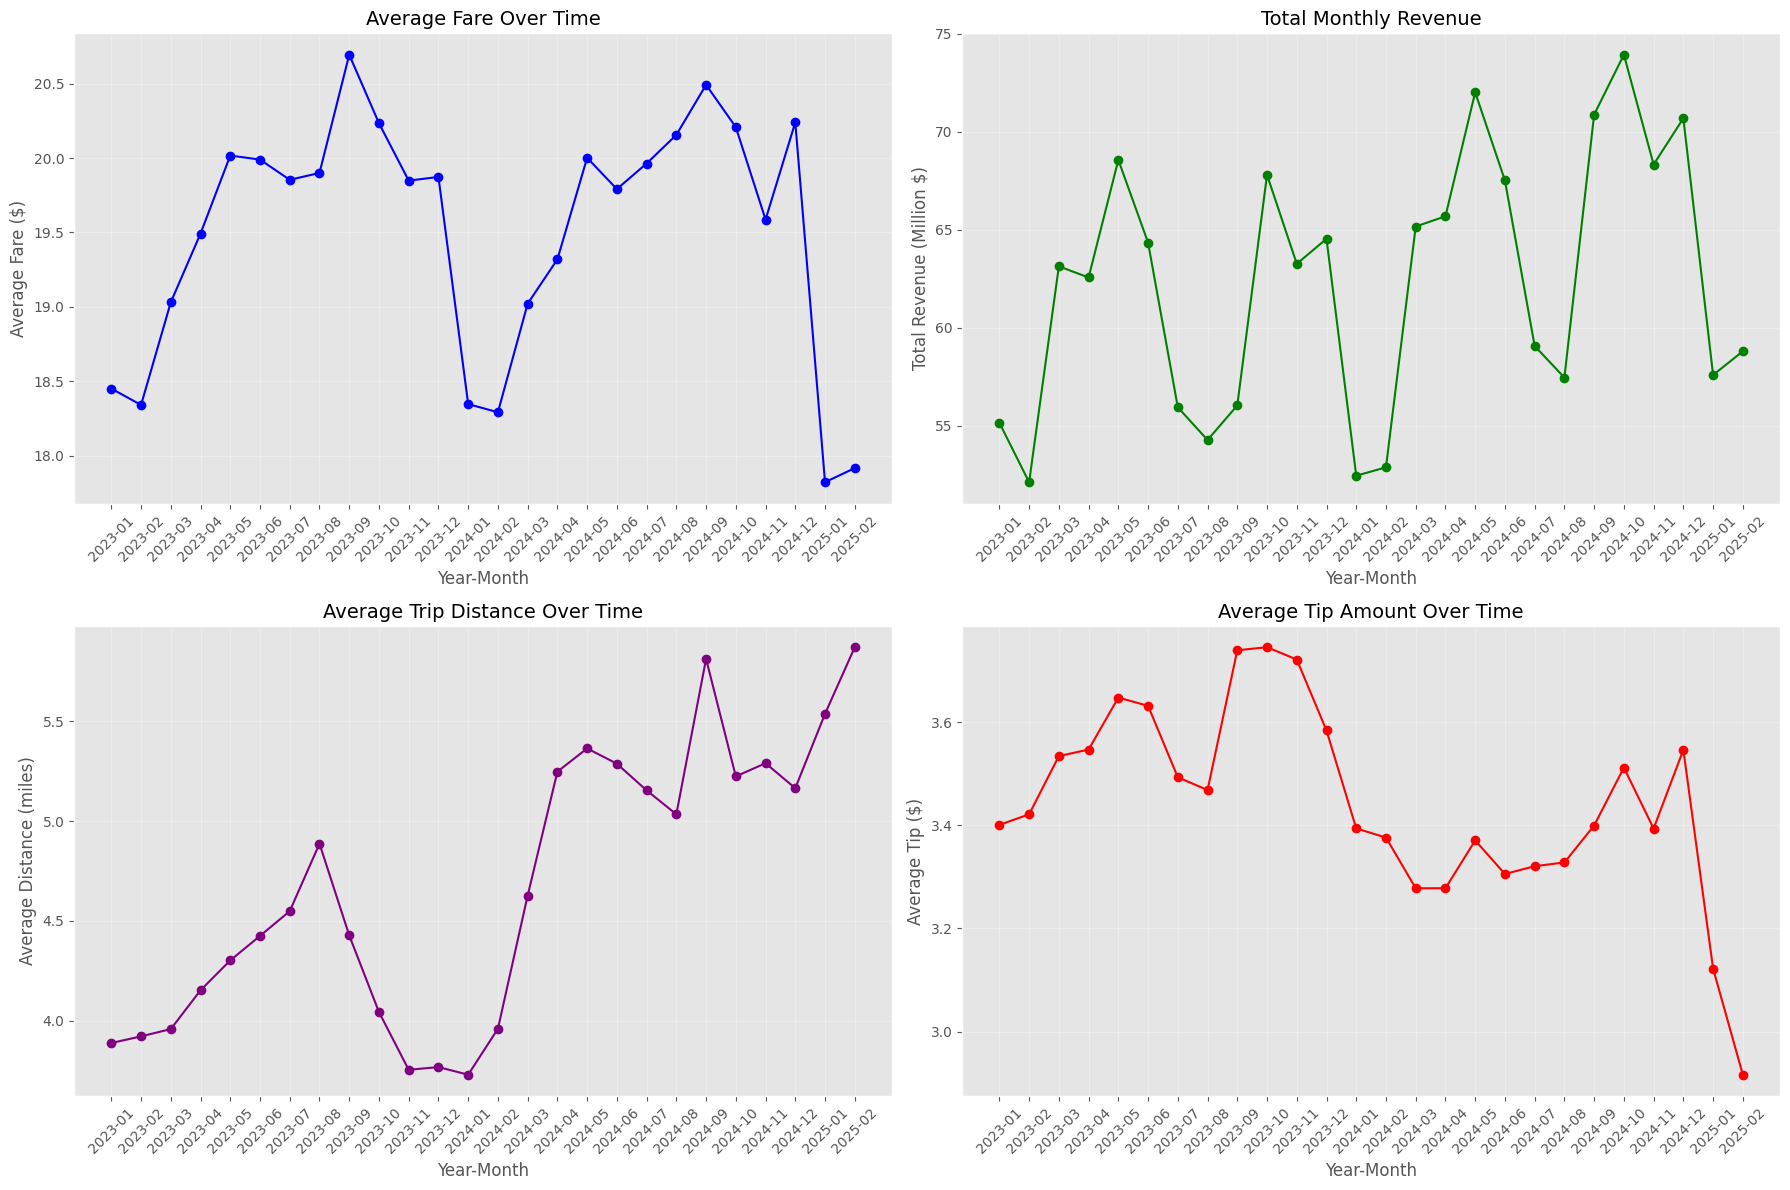

In [51]:
# Plot key metrics over time
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Plot average fare
axs[0, 0].plot(monthly_data_pd['year_month'], monthly_data_pd['avg_fare'], marker='o', linestyle='-', color='blue')
axs[0, 0].set_title('Average Fare Over Time', fontsize=14)
axs[0, 0].set_xlabel('Year-Month', fontsize=12)
axs[0, 0].set_ylabel('Average Fare ($)', fontsize=12)
axs[0, 0].grid(True, alpha=0.3)
axs[0, 0].tick_params(axis='x', rotation=45)

# Plot total revenue
axs[0, 1].plot(monthly_data_pd['year_month'], monthly_data_pd['total_fare'] / 1000000, marker='o', linestyle='-', color='green')
axs[0, 1].set_title('Total Monthly Revenue', fontsize=14)
axs[0, 1].set_xlabel('Year-Month', fontsize=12)
axs[0, 1].set_ylabel('Total Revenue (Million $)', fontsize=12)
axs[0, 1].grid(True, alpha=0.3)
axs[0, 1].tick_params(axis='x', rotation=45)

# Plot average distance
axs[1, 0].plot(monthly_data_pd['year_month'], monthly_data_pd['avg_distance'], marker='o', linestyle='-', color='purple')
axs[1, 0].set_title('Average Trip Distance Over Time', fontsize=14)
axs[1, 0].set_xlabel('Year-Month', fontsize=12)
axs[1, 0].set_ylabel('Average Distance (miles)', fontsize=12)
axs[1, 0].grid(True, alpha=0.3)
axs[1, 0].tick_params(axis='x', rotation=45)

# Plot average tip
axs[1, 1].plot(monthly_data_pd['year_month'], monthly_data_pd['avg_tip'], marker='o', linestyle='-', color='red')
axs[1, 1].set_title('Average Tip Amount Over Time', fontsize=14)
axs[1, 1].set_xlabel('Year-Month', fontsize=12)
axs[1, 1].set_ylabel('Average Tip ($)', fontsize=12)
axs[1, 1].grid(True, alpha=0.3)
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Seasonal Patterns Analysis

Analyze seasonal patterns across years.

Monthly patterns calculation duration: 12.65 seconds


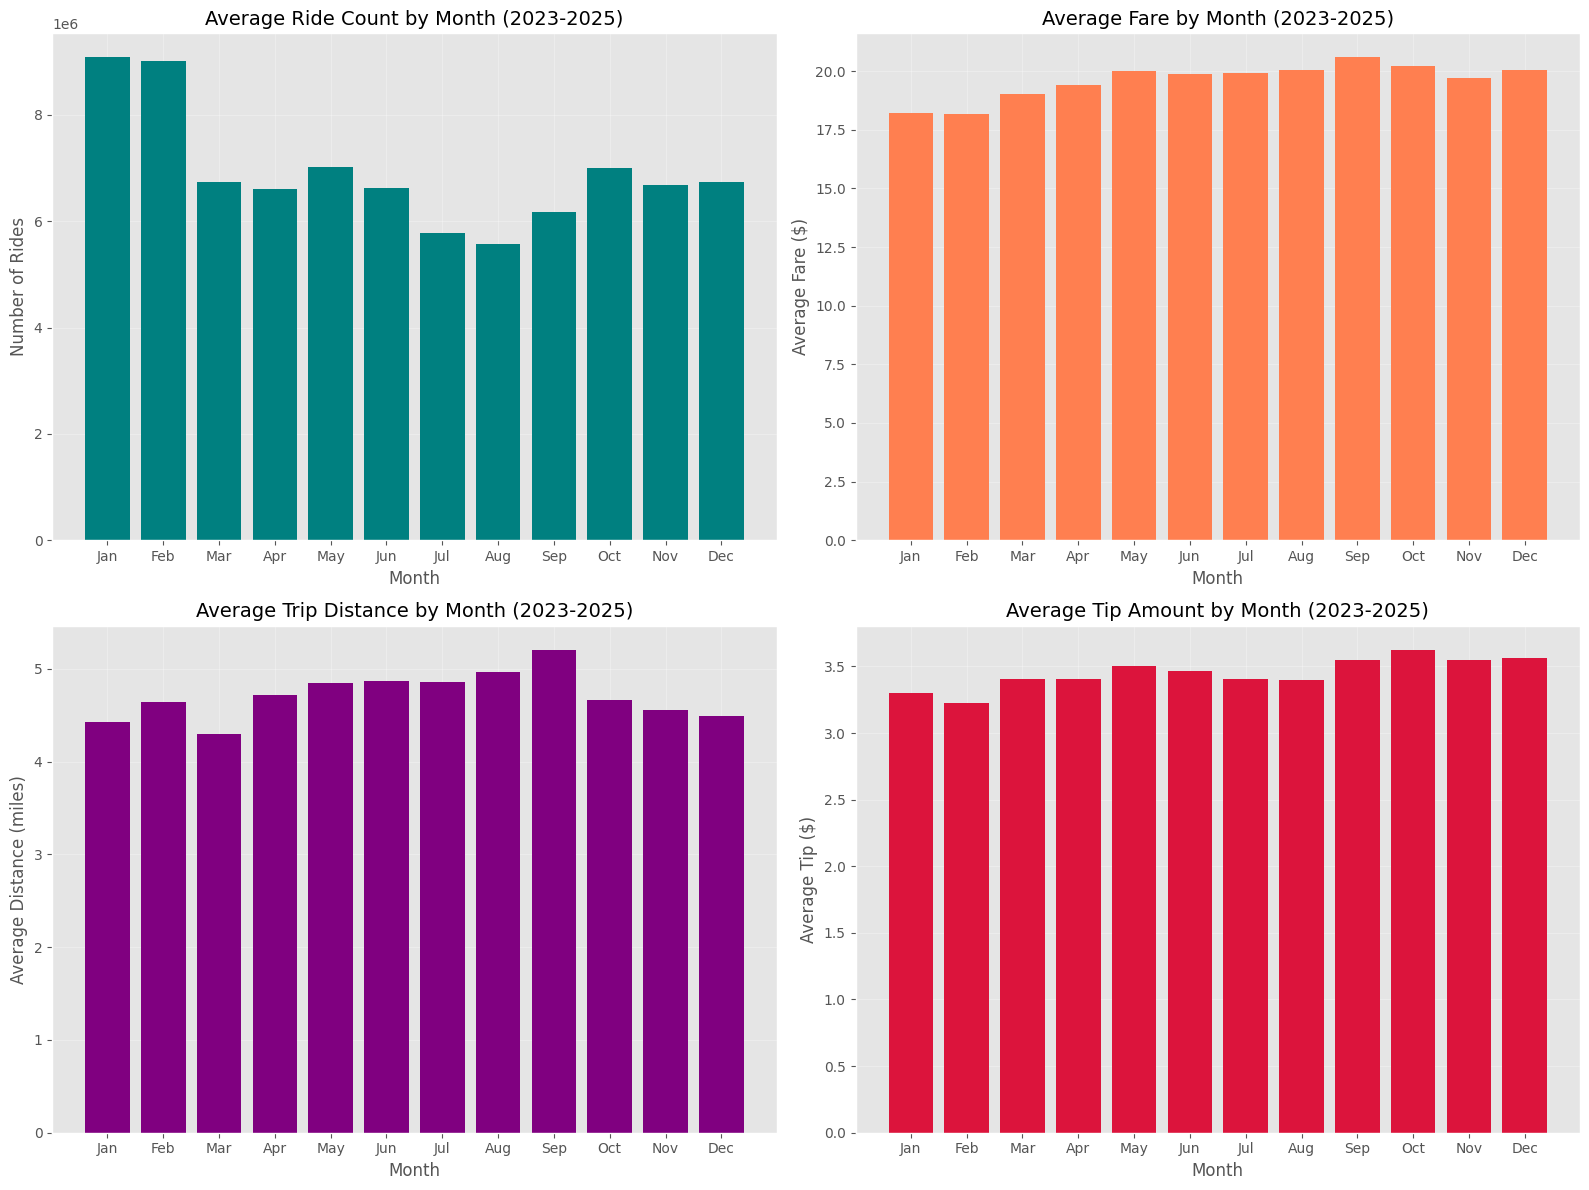

In [52]:
# Analyze monthly patterns across years
start = time.time()
month_patterns = temporal_data.groupBy('month') \
    .agg(count('*').alias('ride_count'),
         avg('fare_amount').alias('avg_fare'),
         avg('trip_distance').alias('avg_distance'),
         avg('tip_amount').alias('avg_tip')) \
    .orderBy('month')
month_patterns.collect()

end = time.time()
print(f"Monthly patterns calculation duration: {end - start:.2f} seconds")

month_patterns_pd = month_patterns.toPandas()

# Map month numbers to names
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
month_patterns_pd['month_name'] = month_patterns_pd['month'].map(month_names)

# Plot monthly patterns
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot ride count by month
axs[0, 0].bar(month_patterns_pd['month_name'], month_patterns_pd['ride_count'], color='teal')
axs[0, 0].set_title('Average Ride Count by Month (2023-2025)', fontsize=14)
axs[0, 0].set_xlabel('Month', fontsize=12)
axs[0, 0].set_ylabel('Number of Rides', fontsize=12)
axs[0, 0].grid(True, alpha=0.3)

# Plot average fare by month
axs[0, 1].bar(month_patterns_pd['month_name'], month_patterns_pd['avg_fare'], color='coral')
axs[0, 1].set_title('Average Fare by Month (2023-2025)', fontsize=14)
axs[0, 1].set_xlabel('Month', fontsize=12)
axs[0, 1].set_ylabel('Average Fare ($)', fontsize=12)
axs[0, 1].grid(True, alpha=0.3)

# Plot average distance by month
axs[1, 0].bar(month_patterns_pd['month_name'], month_patterns_pd['avg_distance'], color='purple')
axs[1, 0].set_title('Average Trip Distance by Month (2023-2025)', fontsize=14)
axs[1, 0].set_xlabel('Month', fontsize=12)
axs[1, 0].set_ylabel('Average Distance (miles)', fontsize=12)
axs[1, 0].grid(True, alpha=0.3)

# Plot average tip by month
axs[1, 1].bar(month_patterns_pd['month_name'], month_patterns_pd['avg_tip'], color='crimson')
axs[1, 1].set_title('Average Tip Amount by Month (2023-2025)', fontsize=14)
axs[1, 1].set_xlabel('Month', fontsize=12)
axs[1, 1].set_ylabel('Average Tip ($)', fontsize=12)
axs[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Day of Week Patterns

Analyze patterns by day of week across the entire dataset.

In [53]:
start = time.time()
temporal_data.createOrReplaceTempView("temporal_data")
result = spark.sql("""
    SELECT
        month,
        COUNT(*) AS ride_count,
        AVG(fare_amount) AS avg_fare,
        AVG(trip_distance) AS avg_distance,
        AVG(tip_amount) AS avg_tip
    FROM temporal_data
    GROUP BY month
    ORDER BY month
""")
result.collect()
end = time.time()
print(f"SQL Duration: {end - start:.2f} seconds")

SQL Duration: 11.00 seconds


SQL Duration: 18.70 seconds


/tmp/ipykernel_39593/3754599436.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_name', y='ride_count', data=day_pattern_pd, ax=axs[0, 0], palette='viridis')
/tmp/ipykernel_39593/3754599436.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_name', y='avg_fare', data=day_pattern_pd, ax=axs[0, 1], palette='magma')
/tmp/ipykernel_39593/3754599436.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_name', y='avg_distance', data=day_pattern_pd, ax=axs[1, 0], palette='cividis')
/tmp/ipykernel_39593/3754599436.py:55: Fut

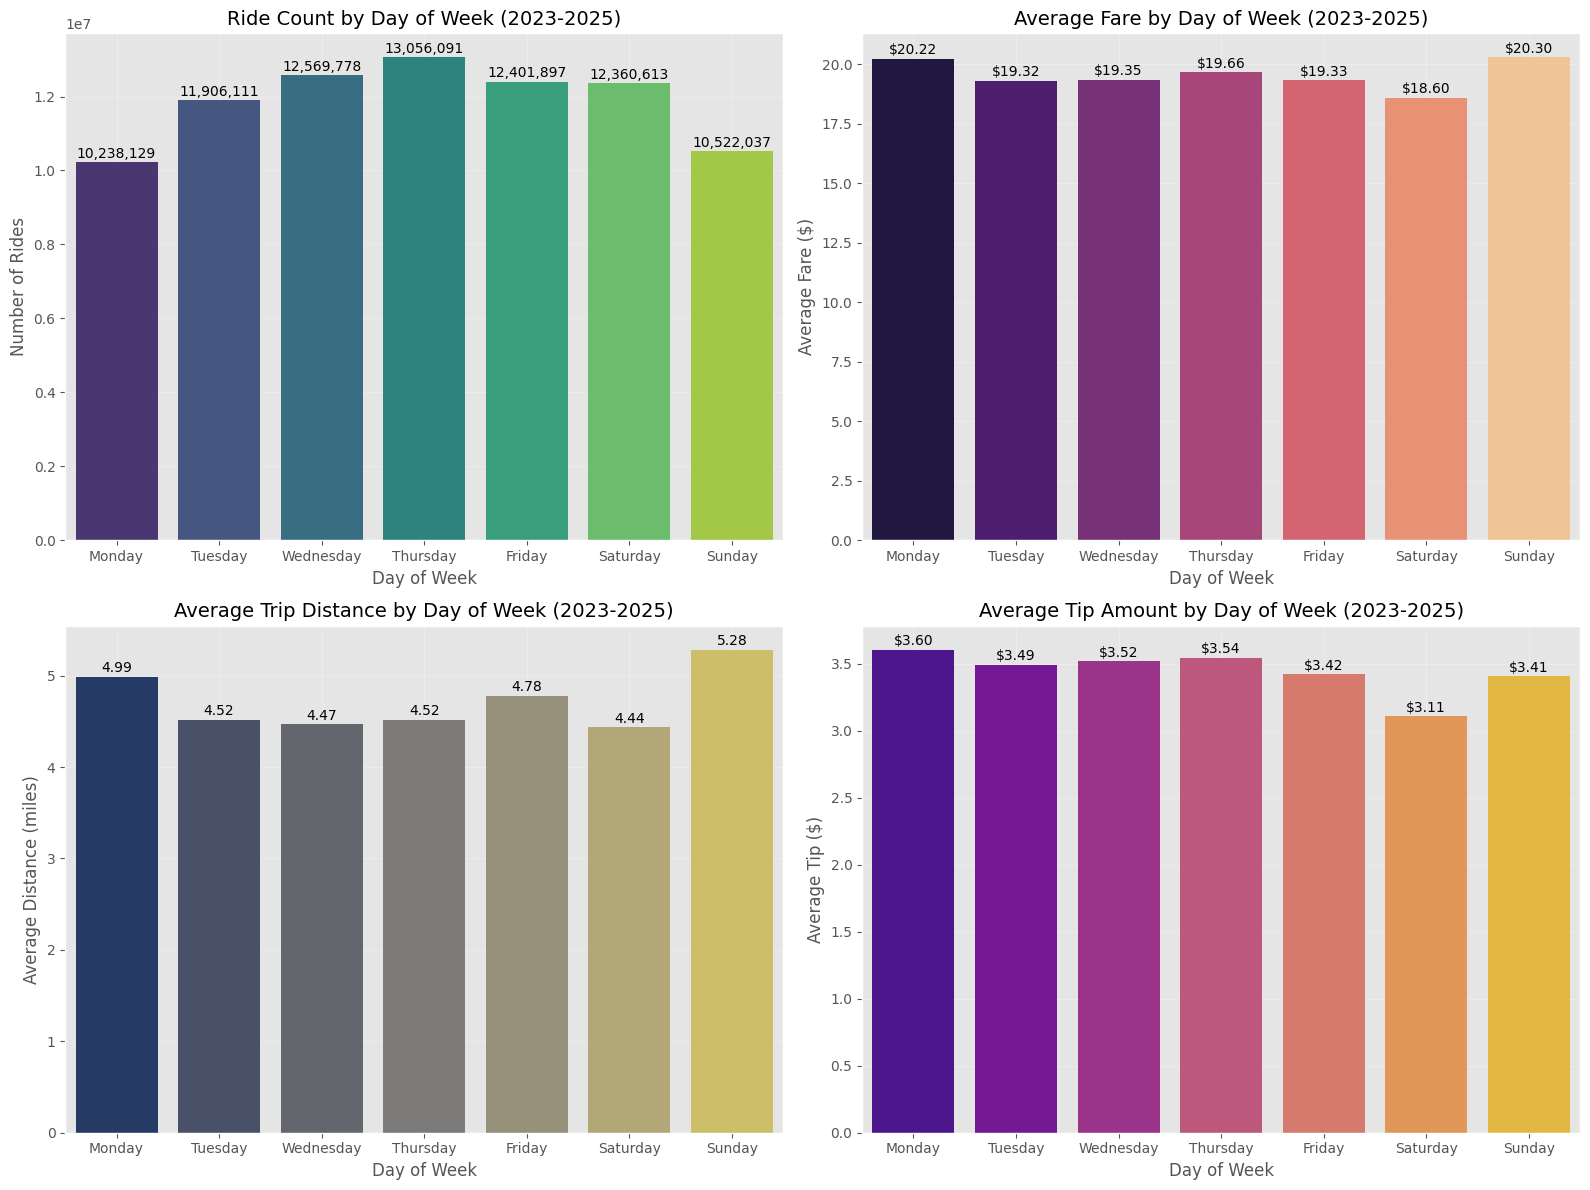

In [54]:
# Day of week pattern
day_mapping = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
              5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
start = time.time()
day_pattern = temporal_data.groupBy('pickup_day') \
    .agg(count('*').alias('ride_count'),
         avg('fare_amount').alias('avg_fare'),
         avg('trip_distance').alias('avg_distance'),
         avg('tip_amount').alias('avg_tip'),
         avg('trip_duration_minutes').alias('avg_duration')) \
    .orderBy('pickup_day')
day_pattern.collect()
end = time.time()
print(f"SQL Duration: {end - start:.2f} seconds")

day_pattern_pd = day_pattern.toPandas()
day_pattern_pd['day_name'] = day_pattern_pd['pickup_day'].map(day_mapping)

# Create a custom order for days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_pattern_pd['day_name'] = pd.Categorical(day_pattern_pd['day_name'], categories=day_order, ordered=True)
day_pattern_pd = day_pattern_pd.sort_values('day_name')

# Plot day of week patterns
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot ride count by day
sns.barplot(x='day_name', y='ride_count', data=day_pattern_pd, ax=axs[0, 0], palette='viridis')
axs[0, 0].set_title('Ride Count by Day of Week (2023-2025)', fontsize=14)
axs[0, 0].set_xlabel('Day of Week', fontsize=12)
axs[0, 0].set_ylabel('Number of Rides', fontsize=12)
axs[0, 0].grid(True, alpha=0.3)
for i, v in enumerate(day_pattern_pd['ride_count']):
    axs[0, 0].text(i, v + (v * 0.01), f'{v:,.0f}', ha='center')

# Plot average fare by day
sns.barplot(x='day_name', y='avg_fare', data=day_pattern_pd, ax=axs[0, 1], palette='magma')
axs[0, 1].set_title('Average Fare by Day of Week (2023-2025)', fontsize=14)
axs[0, 1].set_xlabel('Day of Week', fontsize=12)
axs[0, 1].set_ylabel('Average Fare ($)', fontsize=12)
axs[0, 1].grid(True, alpha=0.3)
for i, v in enumerate(day_pattern_pd['avg_fare']):
    axs[0, 1].text(i, v + (v * 0.01), f'${v:.2f}', ha='center')

# Plot average distance by day
sns.barplot(x='day_name', y='avg_distance', data=day_pattern_pd, ax=axs[1, 0], palette='cividis')
axs[1, 0].set_title('Average Trip Distance by Day of Week (2023-2025)', fontsize=14)
axs[1, 0].set_xlabel('Day of Week', fontsize=12)
axs[1, 0].set_ylabel('Average Distance (miles)', fontsize=12)
axs[1, 0].grid(True, alpha=0.3)
for i, v in enumerate(day_pattern_pd['avg_distance']):
    axs[1, 0].text(i, v + (v * 0.01), f'{v:.2f}', ha='center')

# Plot average tip by day
sns.barplot(x='day_name', y='avg_tip', data=day_pattern_pd, ax=axs[1, 1], palette='plasma')
axs[1, 1].set_title('Average Tip Amount by Day of Week (2023-2025)', fontsize=14)
axs[1, 1].set_xlabel('Day of Week', fontsize=12)
axs[1, 1].set_ylabel('Average Tip ($)', fontsize=12)
axs[1, 1].grid(True, alpha=0.3)
for i, v in enumerate(day_pattern_pd['avg_tip']):
    axs[1, 1].text(i, v + (v * 0.01), f'${v:.2f}', ha='center')

plt.tight_layout()
plt.show()

## 9. Geographic Hotspot Analysis

Identify the most popular pickup and dropoff locations over time.

In [55]:
# Load the taxi zone lookup table to map IDs to names
try:
    taxi_zones = pd.read_csv('taxi_zone_lookup.csv')
    taxi_zone_dict = dict(zip(taxi_zones['LocationID'], taxi_zones['Zone']))
    has_zone_lookup = True
except:
    print("Warning: taxi_zone_lookup.csv not found. Location IDs will be used instead of names.")
    has_zone_lookup = False

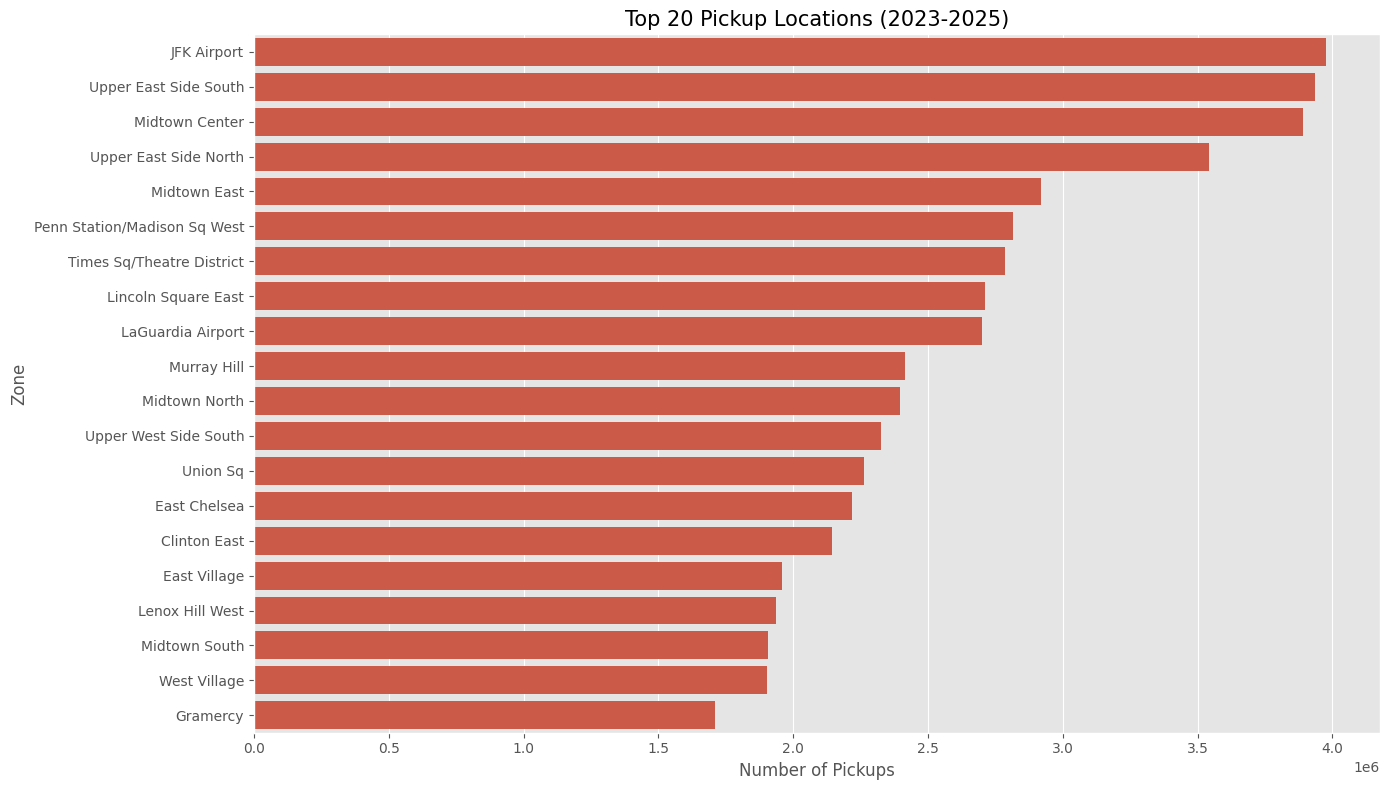

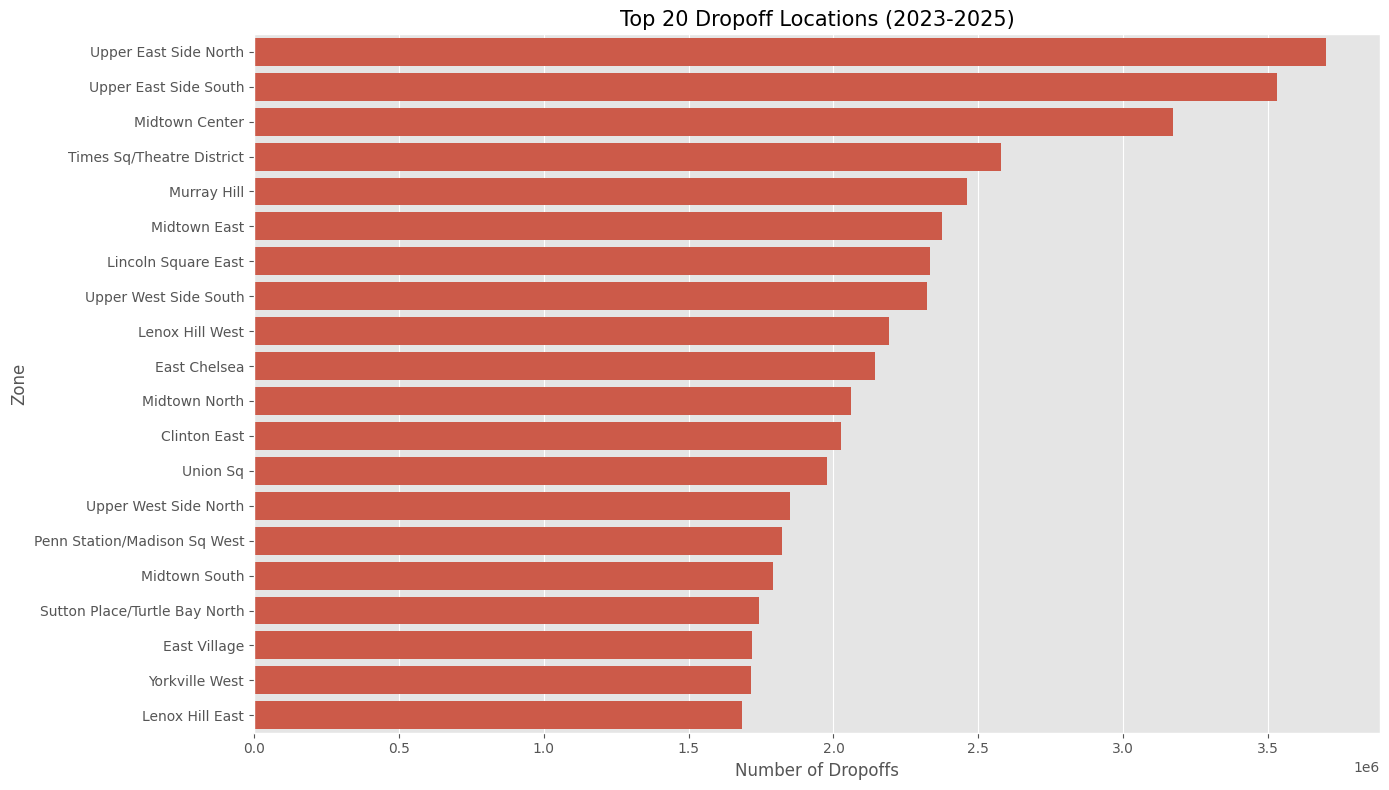

In [56]:
# Get the top 20 pickup locations
top_pickup_locations = temporal_data.groupBy('PULocationID') \
    .count() \
    .orderBy(desc('count')) \
    .limit(20)

# Convert to pandas dataframe and add zone information
top_pickup_pd = top_pickup_locations.toPandas()
# Use the existing taxi_zone_dict to map location IDs to zone names
if has_zone_lookup:
    top_pickup_pd['Zone'] = top_pickup_pd['PULocationID'].map(taxi_zone_dict)
    top_pickup_pd['Borough'] = top_pickup_pd['PULocationID'].map(
        dict(zip(taxi_zones['LocationID'], taxi_zones['Borough'])))

# Get the top 20 dropoff locations
top_dropoff_locations = temporal_data.groupBy('DOLocationID') \
    .count() \
    .orderBy(desc('count')) \
    .limit(20)

# Convert to pandas dataframe and add zone information
top_dropoff_pd = top_dropoff_locations.toPandas()
# Use the existing taxi_zone_dict to map location IDs to zone names
if has_zone_lookup:
    top_dropoff_pd['Zone'] = top_dropoff_pd['DOLocationID'].map(taxi_zone_dict)
    top_dropoff_pd['Borough'] = top_dropoff_pd['DOLocationID'].map(
        dict(zip(taxi_zones['LocationID'], taxi_zones['Borough'])))

# Plot top pickup locations
plt.figure(figsize=(14, 8))
sns.barplot(x='count', y='Zone', data=top_pickup_pd)
plt.title('Top 20 Pickup Locations (2023-2025)', fontsize=15)
plt.xlabel('Number of Pickups', fontsize=12)
plt.ylabel('Zone', fontsize=12)
plt.tight_layout()
plt.show()

# Plot top dropoff locations
plt.figure(figsize=(14, 8))
sns.barplot(x='count', y='Zone', data=top_dropoff_pd)
plt.title('Top 20 Dropoff Locations (2023-2025)', fontsize=15)
plt.xlabel('Number of Dropoffs', fontsize=12)
plt.ylabel('Zone', fontsize=12)
plt.tight_layout()
plt.show()

## Top Taxi Routes Analysis

Analyze the most popular routes (pickup → dropoff pairs) in the dataset.

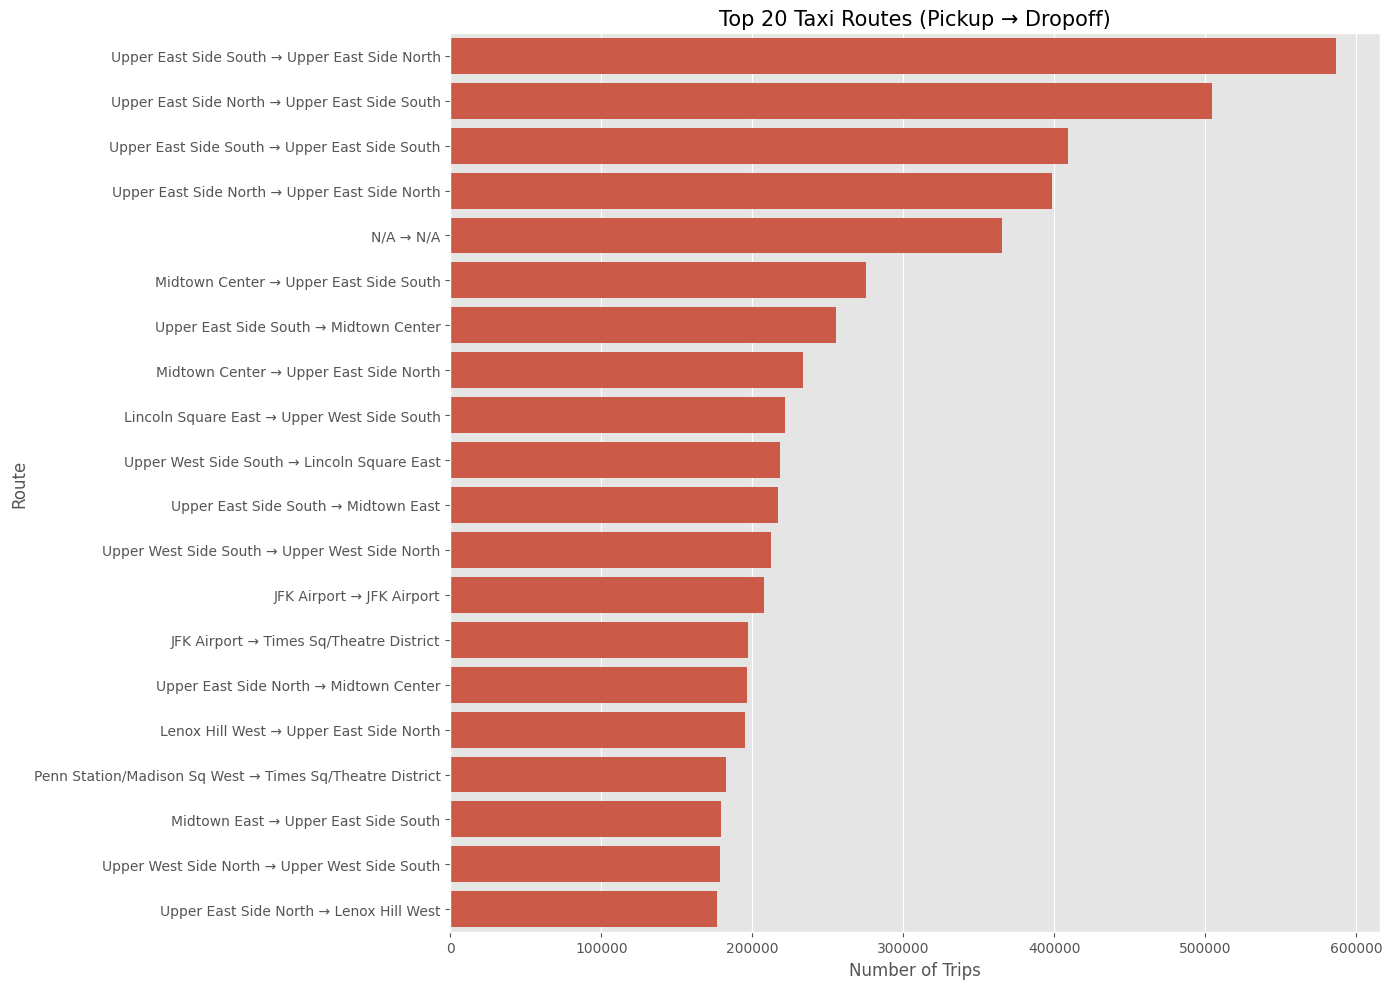

In [57]:
# Analyze flow between specific pickup and dropoff locations
# Get the top 20 pickup-dropoff pairs
top_routes = all_data.groupBy('PULocationID', 'DOLocationID') \
    .count() \
    .orderBy(desc('count')) \
    .limit(20)

# Load the taxi zone lookup data
taxi_zones = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)

# Join with zone information
top_routes_with_zones = top_routes \
    .join(taxi_zones.alias('pickup_zone'), top_routes.PULocationID == col('pickup_zone.LocationID')) \
    .join(taxi_zones.alias('dropoff_zone'), top_routes.DOLocationID == col('dropoff_zone.LocationID')) \
    .select(
        'PULocationID', 
        'DOLocationID', 
        col('pickup_zone.Zone').alias('Pickup_Zone'),
        col('dropoff_zone.Zone').alias('Dropoff_Zone'),
        'count'
    ).toPandas()

# Display the top routes
top_routes_with_zones['Route'] = top_routes_with_zones['Pickup_Zone'] + ' → ' + top_routes_with_zones['Dropoff_Zone']

# Sort the DataFrame so the bar chart is ordered from lowest to highest count (so highest is at the top)
top_routes_with_zones_sorted = top_routes_with_zones.sort_values('count', ascending=False)

plt.figure(figsize=(14, 10))
sns.barplot(x='count', y='Route', data=top_routes_with_zones_sorted)
plt.title('Top 20 Taxi Routes (Pickup → Dropoff)', fontsize=15)
plt.xlabel('Number of Trips', fontsize=12)
plt.ylabel('Route', fontsize=12)
plt.tight_layout()
plt.show()

## 10. Payment Method Analysis

Analyze payment methods and their trends over time.

SQL Duration: 13.20 seconds


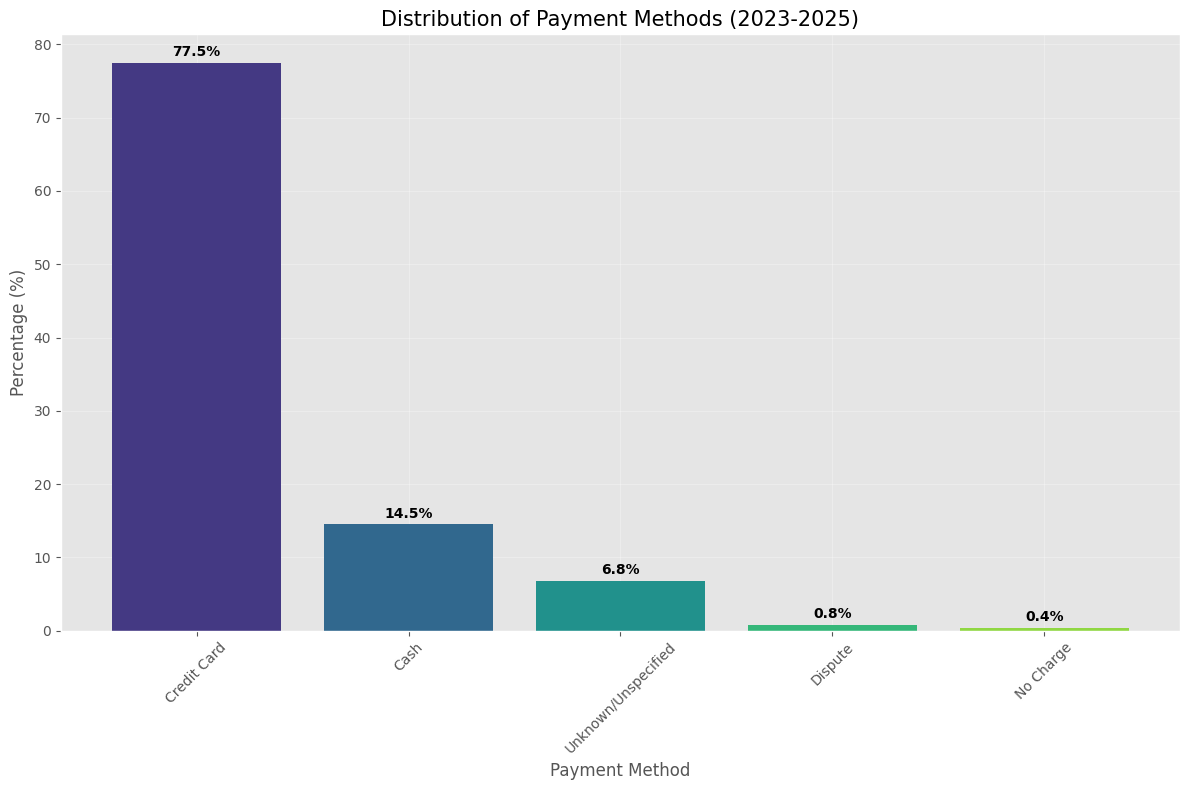

In [58]:
# Bar chart of payment method distribution
start = time.time()
payment_distribution = temporal_data.groupBy('payment_type') \
    .agg(count('*').alias('ride_count'),
         avg('tip_amount').alias('avg_tip'),
         avg('fare_amount').alias('avg_fare')) \
    .orderBy(desc('ride_count'))
    
payment_distribution.collect()
end = time.time()
print(f"SQL Duration: {end - start:.2f} seconds")
# Map payment type codes to descriptive names
payment_type_mapping = {
    0: 'Unknown/Unspecified',
    1: 'Credit Card', 
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided Trip'
}

payment_distribution_pd = payment_distribution.toPandas()
payment_distribution_pd['payment_name'] = payment_distribution_pd['payment_type'].map(payment_type_mapping)

# Fill any NaN values in payment_name with a default value
payment_distribution_pd['payment_name'] = payment_distribution_pd['payment_name'].fillna('Unknown/Unspecified')

# Calculate percentages
payment_distribution_pd['percentage'] = (payment_distribution_pd['ride_count'] / payment_distribution_pd['ride_count'].sum()) * 100

# Plot payment method distribution as a bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(payment_distribution_pd['payment_name'], 
         payment_distribution_pd['percentage'],
         color=sns.color_palette('viridis', len(payment_distribution_pd)))

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.title('Distribution of Payment Methods (2023-2025)', fontsize=15)
plt.xlabel('Payment Method', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


SQL Duration: 15.78 seconds


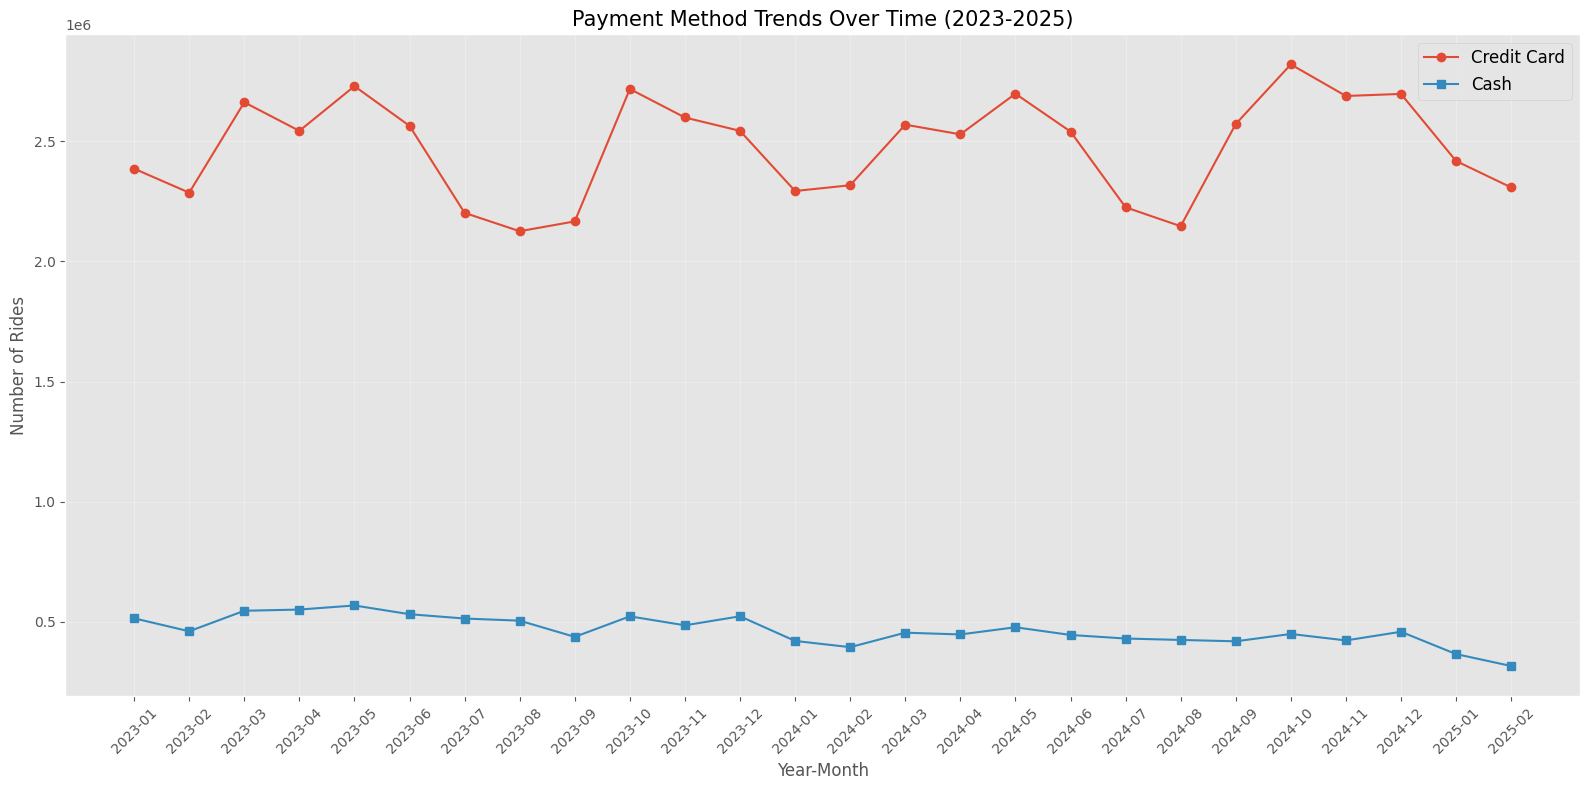

In [59]:
# Payment methods over time
start = time.time()
payment_trends = temporal_data.groupBy('year_month', 'payment_type') \
    .agg(count('*').alias('ride_count')) \
    .orderBy('year_month', 'payment_type')
    
payment_trends.collect()
end = time.time()
print(f"SQL Duration: {end - start:.2f} seconds")

# Convert to pandas
payment_trends_pd = payment_trends.toPandas()

# Map payment types to names
payment_trends_pd['payment_name'] = payment_trends_pd['payment_type'].map(payment_type_mapping)

# Filter to only include major payment types (Credit Card and Cash)
major_payment_trends = payment_trends_pd[payment_trends_pd['payment_type'].isin([1, 2])]

# Pivot the data to get payment types as columns
pivot_payment = major_payment_trends.pivot(index='year_month', columns='payment_name', values='ride_count').reset_index()
pivot_payment.fillna(0, inplace=True)

# Plot the trends
plt.figure(figsize=(16, 8))
plt.plot(pivot_payment['year_month'], pivot_payment['Credit Card'], marker='o', linestyle='-', label='Credit Card')
plt.plot(pivot_payment['year_month'], pivot_payment['Cash'], marker='s', linestyle='-', label='Cash')
plt.title('Payment Method Trends Over Time (2023-2025)', fontsize=15)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Rides', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 11. Trip Distance and Duration Analysis

Analyze trip distance and duration patterns over time.

Filtering duration: 0.02 seconds


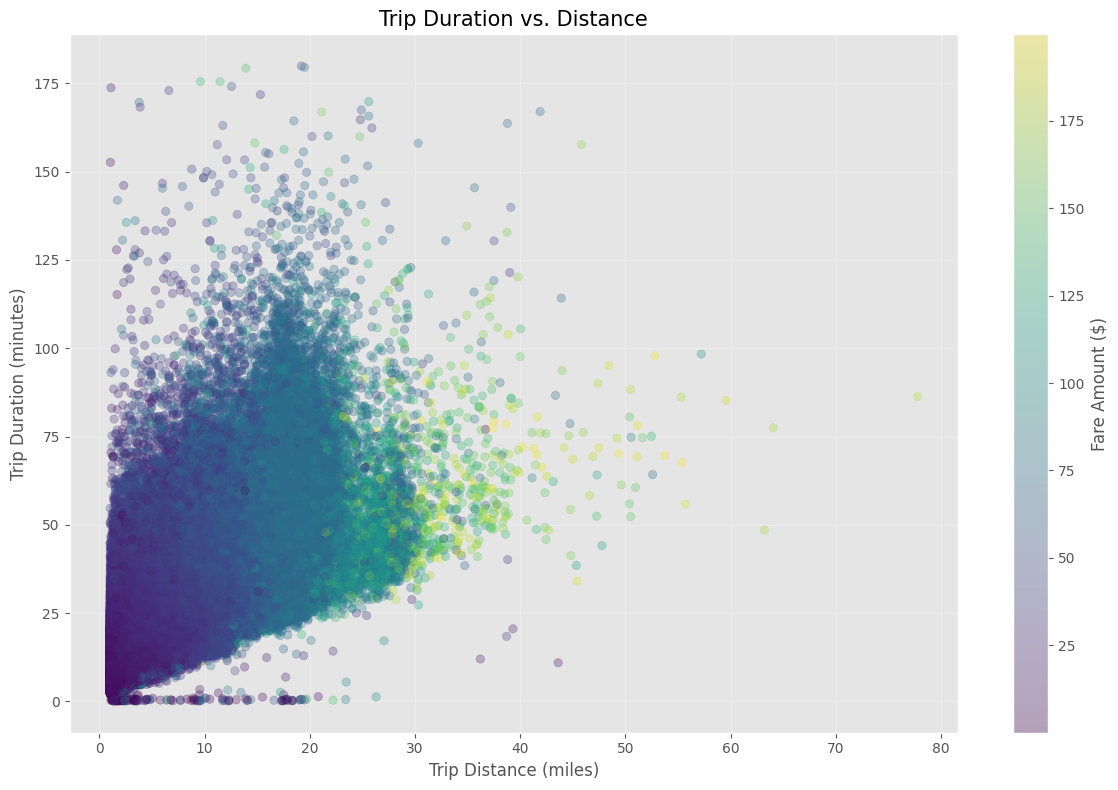

In [60]:
# Filter out extreme outliers for trip distance and duration
start = time.time()
filtered_trips = temporal_data.filter(
    (col('trip_distance') > 1) & 
    (col('trip_distance') < 100) & 
    (col('trip_duration_minutes') > 0.1) & 
    (col('trip_duration_minutes') < 180)  # exclude trips longer than 3 hours
)
end = time.time()
print(f"Filtering duration: {end - start:.2f} seconds")

# Sample the data for visualization
sampled_trips = filtered_trips.select('trip_distance', 'trip_duration_minutes', 'fare_amount') \
    .sample(fraction=0.01, seed=42) \
    .toPandas()

# Scatter plot of trip distance vs. duration
plt.figure(figsize=(12, 8))
plt.scatter(sampled_trips['trip_distance'], sampled_trips['trip_duration_minutes'], 
            alpha=0.3, c=sampled_trips['fare_amount'], cmap='viridis')
plt.colorbar(label='Fare Amount ($)')
plt.title('Trip Duration vs. Distance', fontsize=15)
plt.xlabel('Trip Distance (miles)', fontsize=12)
plt.ylabel('Trip Duration (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

SQL Duration: 15.70 seconds


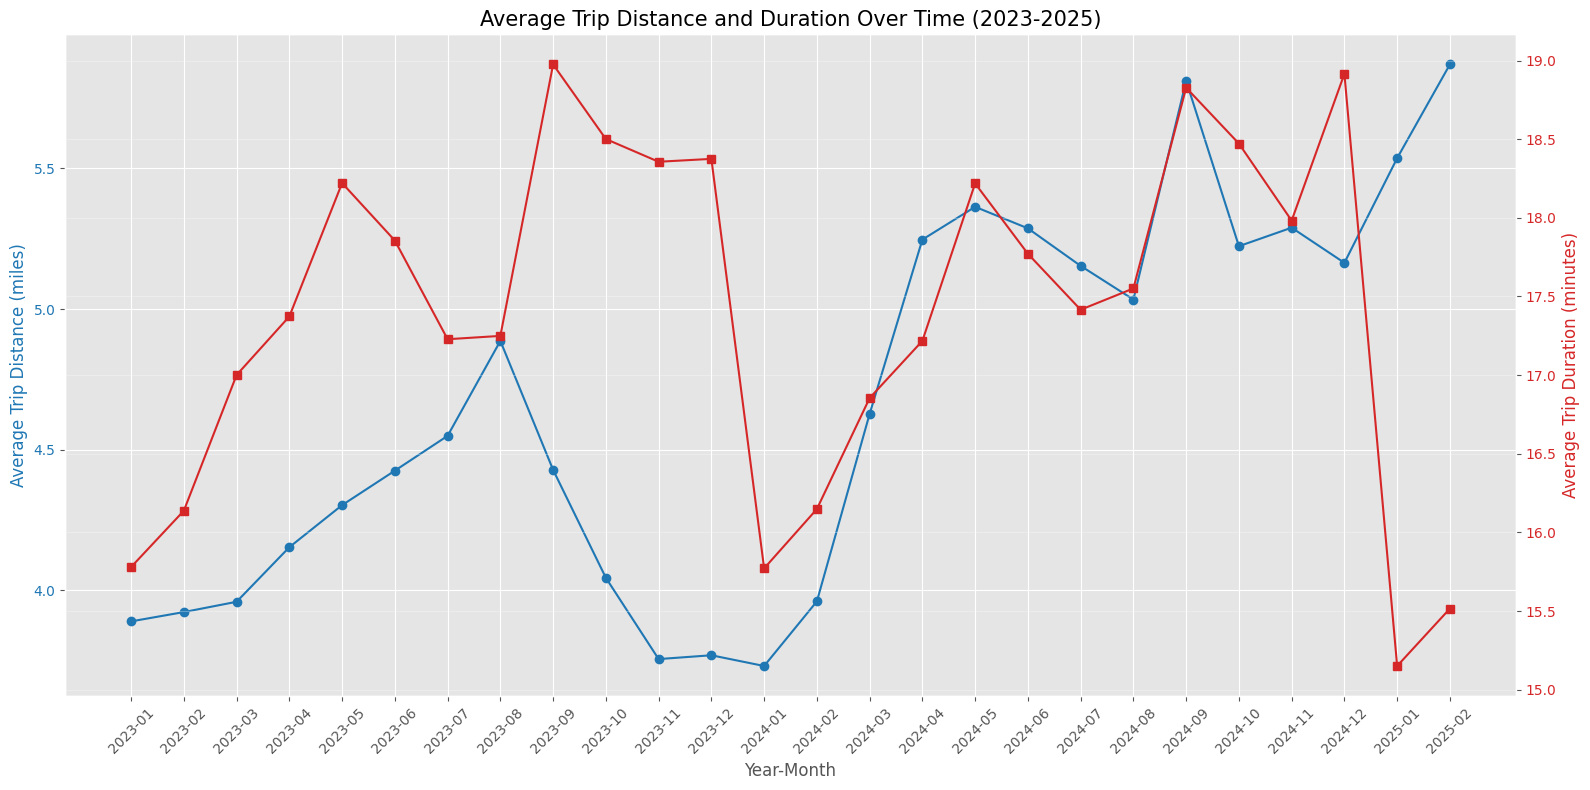

In [61]:
# Monthly average trip distance and duration
start = time.time()
monthly_trip_metrics = temporal_data.groupBy('year_month') \
    .agg(avg('trip_distance').alias('avg_distance'),
         avg('trip_duration_minutes').alias('avg_duration'),
         avg('fare_amount').alias('avg_fare')) \
    .orderBy('year_month')

monthly_trip_metrics.collect()
end = time.time()
print(f"SQL Duration: {end - start:.2f} seconds")

monthly_trip_metrics_pd = monthly_trip_metrics.toPandas()

# Plot
fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'tab:blue'
ax1.set_xlabel('Year-Month', fontsize=12)
ax1.set_ylabel('Average Trip Distance (miles)', color=color, fontsize=12)
ax1.plot(monthly_trip_metrics_pd['year_month'], monthly_trip_metrics_pd['avg_distance'], 
         color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()  # Create a second y-axis
color = 'tab:red'
ax2.set_ylabel('Average Trip Duration (minutes)', color=color, fontsize=12)
ax2.plot(monthly_trip_metrics_pd['year_month'], monthly_trip_metrics_pd['avg_duration'], 
         color=color, marker='s', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Average Trip Distance and Duration Over Time (2023-2025)', fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Hourly Patterns Analysis

Analyze patterns by hour of day across the entire dataset.

SQL Duration: 16.11 seconds


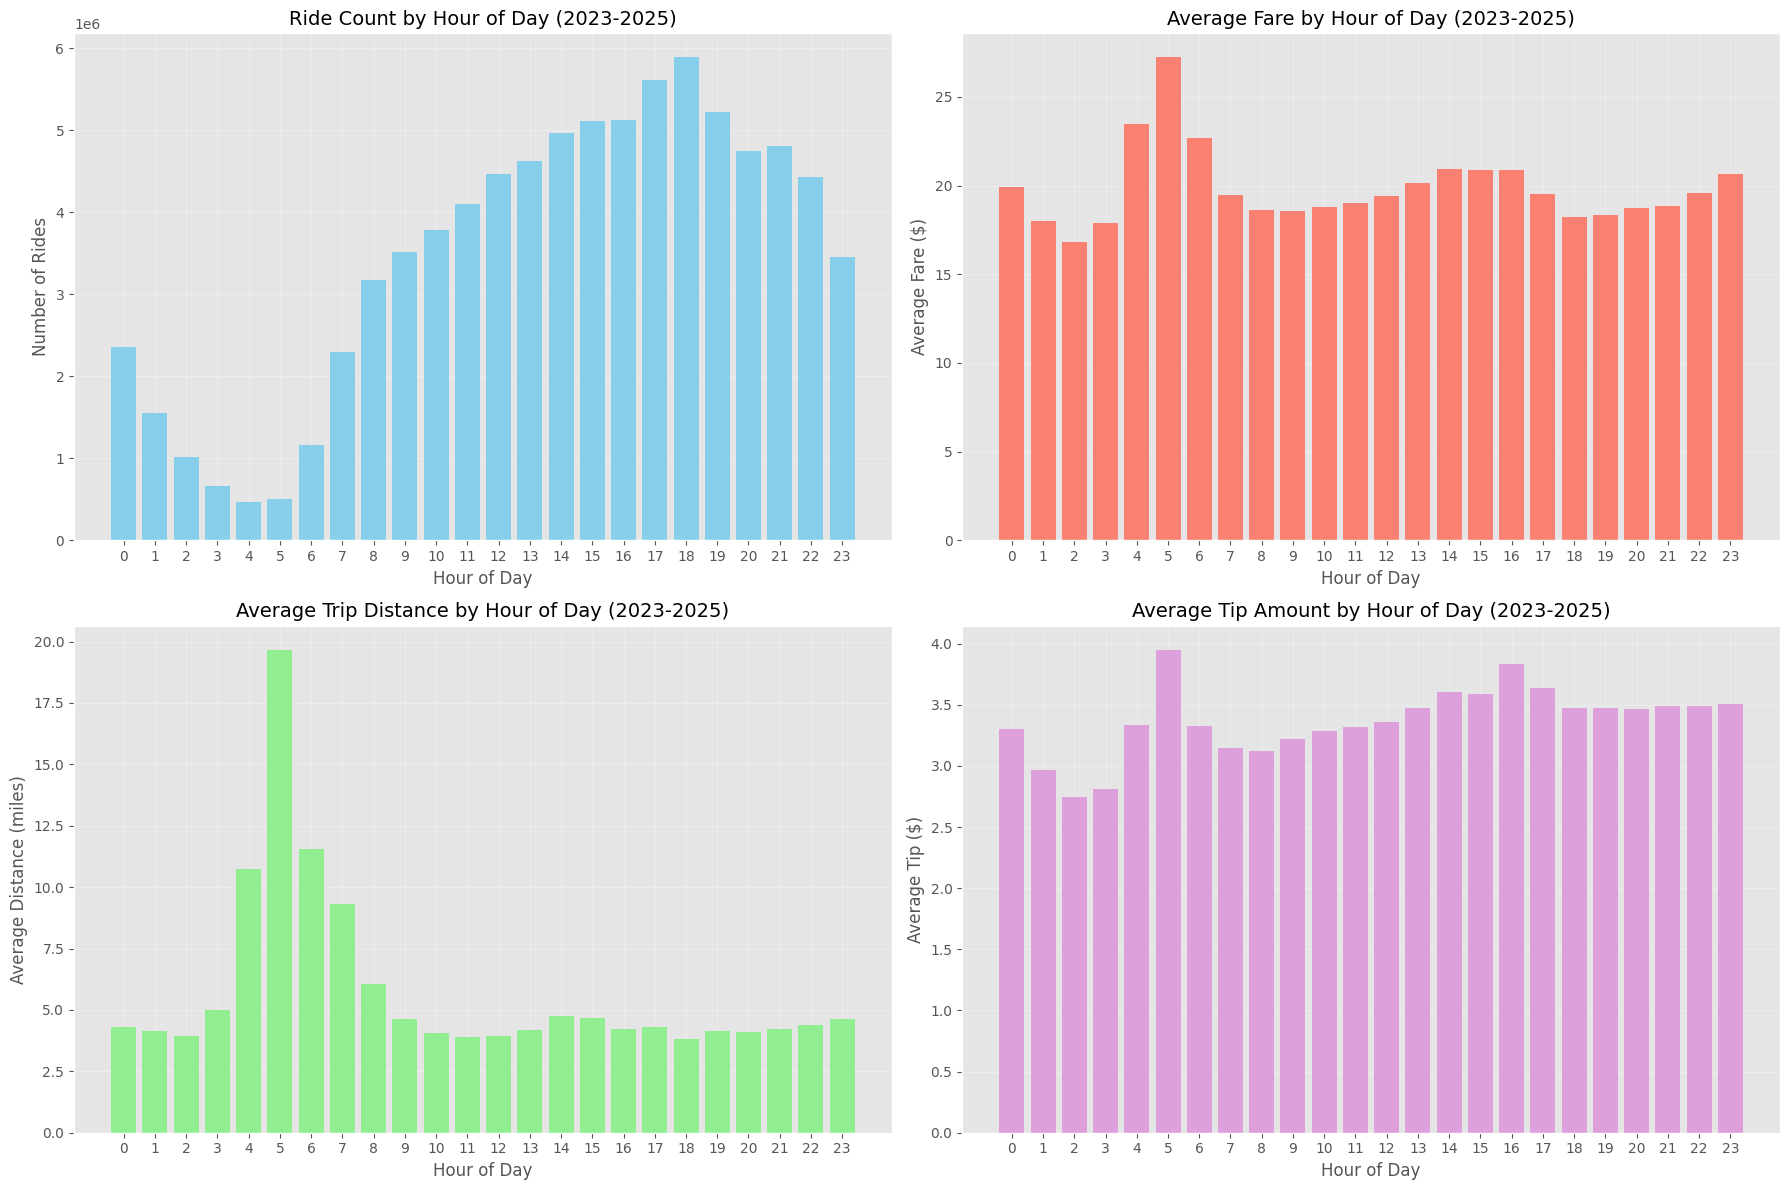

In [62]:
start = time.time()
# For more efficient performance on large datasets, we'll create a temporary view
temporal_data.createOrReplaceTempView("taxi_data_view")
# Use SparkSQL for hourly patterns analysis
hourly_patterns = spark.sql("""
    SELECT 
        pickup_hour,
        COUNT(*) AS ride_count,
        AVG(fare_amount) AS avg_fare,
        AVG(tip_amount) AS avg_tip,
        AVG(trip_distance) AS avg_distance,
        AVG(trip_duration_minutes) AS avg_duration
    FROM 
        taxi_data_view
    GROUP BY 
        pickup_hour
    ORDER BY 
        pickup_hour
""")
hourly_patterns.collect()
end = time.time()
print(f"SQL Duration: {end - start:.2f} seconds")


hourly_patterns_pd = hourly_patterns.toPandas()

# Plot hourly patterns
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Plot ride count by hour
axs[0, 0].bar(hourly_patterns_pd['pickup_hour'], hourly_patterns_pd['ride_count'], color='skyblue')
axs[0, 0].set_title('Ride Count by Hour of Day (2023-2025)', fontsize=14)
axs[0, 0].set_xlabel('Hour of Day', fontsize=12)
axs[0, 0].set_ylabel('Number of Rides', fontsize=12)
axs[0, 0].set_xticks(range(0, 24))
axs[0, 0].grid(True, alpha=0.3)

# Plot average fare by hour
axs[0, 1].bar(hourly_patterns_pd['pickup_hour'], hourly_patterns_pd['avg_fare'], color='salmon')
axs[0, 1].set_title('Average Fare by Hour of Day (2023-2025)', fontsize=14)
axs[0, 1].set_xlabel('Hour of Day', fontsize=12)
axs[0, 1].set_ylabel('Average Fare ($)', fontsize=12)
axs[0, 1].set_xticks(range(0, 24))
axs[0, 1].grid(True, alpha=0.3)

# Plot average distance by hour
axs[1, 0].bar(hourly_patterns_pd['pickup_hour'], hourly_patterns_pd['avg_distance'], color='lightgreen')
axs[1, 0].set_title('Average Trip Distance by Hour of Day (2023-2025)', fontsize=14)
axs[1, 0].set_xlabel('Hour of Day', fontsize=12)
axs[1, 0].set_ylabel('Average Distance (miles)', fontsize=12)
axs[1, 0].set_xticks(range(0, 24))
axs[1, 0].grid(True, alpha=0.3)

# Plot average tip by hour
axs[1, 1].bar(hourly_patterns_pd['pickup_hour'], hourly_patterns_pd['avg_tip'], color='plum')
axs[1, 1].set_title('Average Tip Amount by Hour of Day (2023-2025)', fontsize=14)
axs[1, 1].set_xlabel('Hour of Day', fontsize=12)
axs[1, 1].set_ylabel('Average Tip ($)', fontsize=12)
axs[1, 1].set_xticks(range(0, 24))
axs[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Pickup Locations Analysis

Analyze which pickup locations generate the most total amount of money for taxi drivers.

In [63]:
# Analyze which pickup locations generate the most total amount of money for taxi drivers
from pyspark.sql.functions import sum as spark_sum, desc, col, round as spark_round

# Ensure taxi zone lookup data is available
if not 'taxi_zones_spark_df' in locals():
    try:
        taxi_zones_spark_df = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
    except:
        print("Warning: taxi_zone_lookup.csv not found. Location IDs will be used without zone names.")

start = time.time()
# Group by pickup location ID and sum the total_amount
pickup_total_revenue = temporal_data.groupBy('PULocationID') \
    .agg(
        spark_sum('total_amount').alias('total_revenue'),
        count('*').alias('trip_count')
    ) \
    .orderBy(desc('total_revenue'))

# Join with zone information to get the names
pickup_revenue_with_names = pickup_total_revenue \
    .join(taxi_zones_spark_df, pickup_total_revenue.PULocationID == taxi_zones_spark_df.LocationID) \
    .select(
        col('PULocationID'),
        col('Zone').alias('Pickup_Zone'),
        col('Borough').alias('Pickup_Borough'),
        spark_round(col('total_revenue'), 2).alias('total_revenue'),
        col('trip_count')
    )
pickup_revenue_with_names.collect()
end = time.time()
print(f"SQL Duration: {end - start:.2f} seconds")

# Take top 20 for visualization
top_revenue_locations = pickup_revenue_with_names.orderBy(desc('total_revenue')).limit(20)
top_revenue_pd = top_revenue_locations.toPandas()

# Calculate revenue per trip for each location
top_revenue_pd['revenue_per_trip'] = top_revenue_pd['total_revenue'] / top_revenue_pd['trip_count']

# Display the results in a table
print("Top 20 Pickup Locations by Total Revenue:")
display(top_revenue_pd[['Pickup_Zone', 'Pickup_Borough', 'total_revenue', 'trip_count', 'revenue_per_trip']])

SQL Duration: 13.29 seconds
Top 20 Pickup Locations by Total Revenue:


,Pickup_Zone,Pickup_Borough,total_revenue,trip_count,revenue_per_trip
0,JFK Airport,Queens,3.229558e+08,3977526,81.195148
1,LaGuardia Airport,Queens,1.822565e+08,2700155,67.498524
2,Midtown Center,Manhattan,9.790712e+07,3890484,25.165795
3,Upper East Side South,Manhattan,8.125007e+07,3934089,20.652831
4,Times Sq/Theatre District,Manhattan,7.996635e+07,2785149,28.711697
5,Upper East Side North,Manhattan,7.489795e+07,3543695,21.135552
6,Midtown East,Manhattan,7.143599e+07,2920894,24.456892
7,Penn Station/Madison Sq West,Manhattan,7.133255e+07,2815487,25.335778
8,Lincoln Square East,Manhattan,6.039422e+07,2711583,22.272679
9,Midtown North,Manhattan,6.006978e+07,2395029,25.081023


/tmp/ipykernel_39593/1442087980.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  revenue_bars = sns.barplot(x='total_revenue', y='Pickup_Zone', data=top_revenue_pd, palette='viridis')


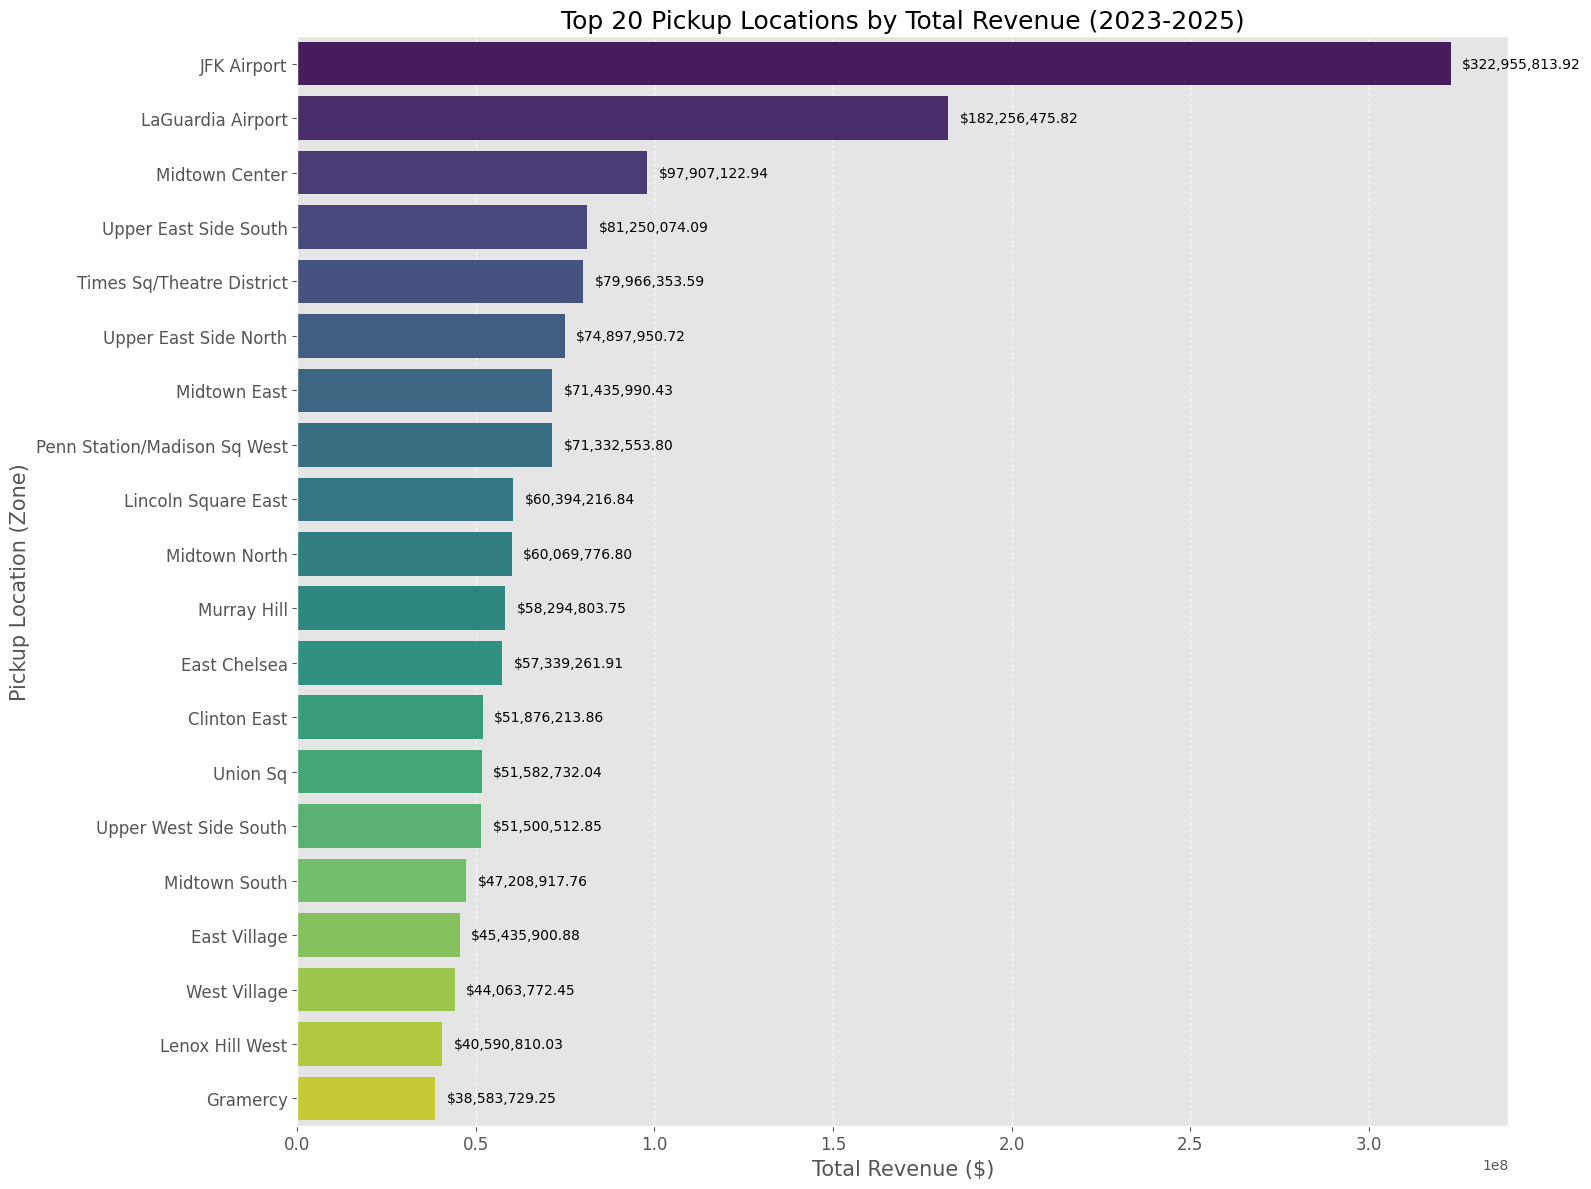

In [64]:
# Visualize the top pickup locations by total revenue
plt.figure(figsize=(16, 12))
revenue_bars = sns.barplot(x='total_revenue', y='Pickup_Zone', data=top_revenue_pd, palette='viridis')
plt.title('Top 20 Pickup Locations by Total Revenue (2023-2025)', fontsize=18)
plt.xlabel('Total Revenue ($)', fontsize=15)
plt.ylabel('Pickup Location (Zone)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add revenue labels to the bars
for i, v in enumerate(top_revenue_pd['total_revenue']):
    revenue_bars.text(v + (top_revenue_pd['total_revenue'].max() * 0.01), i, f'${v:,.2f}', color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Pickup Locations with Highest Average Total Amount

Analyze which pickup locations have the highest average `total_amount`.

/tmp/ipykernel_39593/2221645108.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  revenue_bars = sns.barplot(


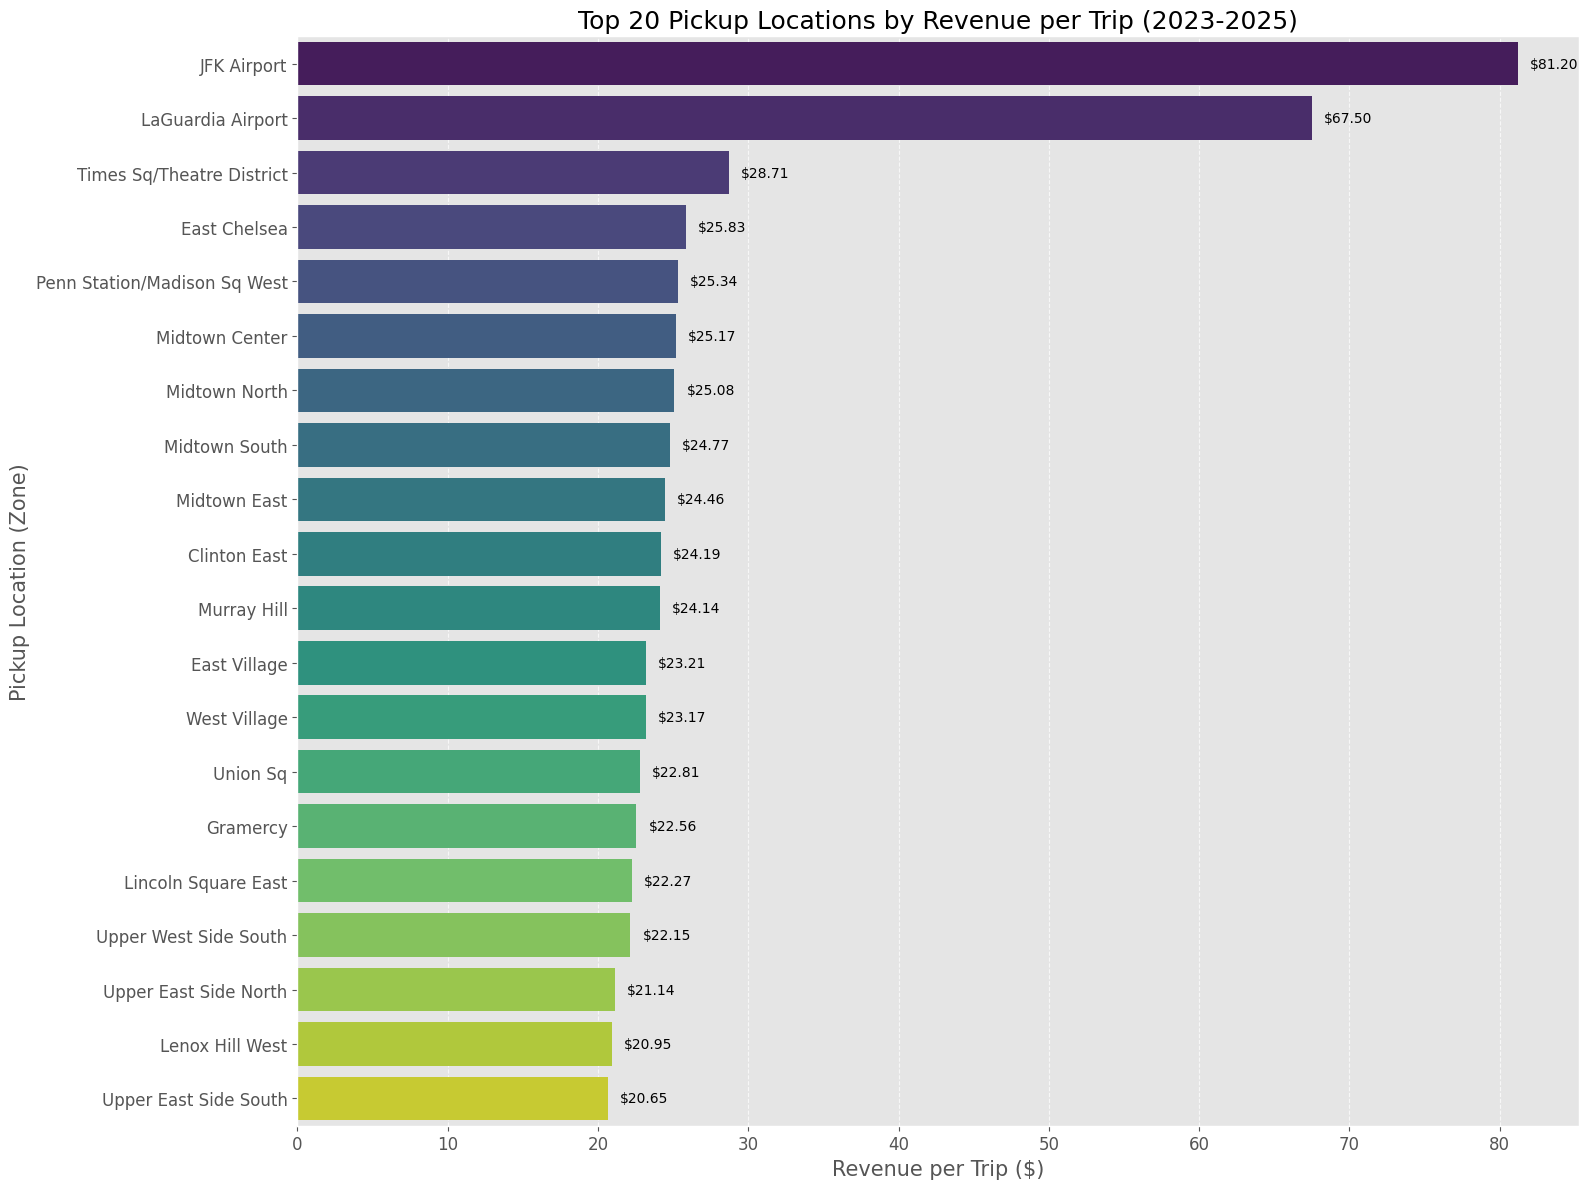

In [65]:
# Visualize the top pickup locations by revenue per trip, ordered descending
top_revenue_pd_sorted = top_revenue_pd.sort_values('revenue_per_trip', ascending=False)

plt.figure(figsize=(16, 12))
revenue_bars = sns.barplot(
    x='revenue_per_trip', 
    y='Pickup_Zone', 
    data=top_revenue_pd_sorted, 
    palette='viridis'
)
plt.title('Top 20 Pickup Locations by Revenue per Trip (2023-2025)', fontsize=18)
plt.xlabel('Revenue per Trip ($)', fontsize=15)
plt.ylabel('Pickup Location (Zone)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add revenue labels to the bars
for i, v in enumerate(top_revenue_pd_sorted['revenue_per_trip']):
    revenue_bars.text(v + (top_revenue_pd_sorted['revenue_per_trip'].max() * 0.01), i, f'${v:.2f}', color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipykernel_39593/651597709.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  trip_count_bars = sns.barplot(


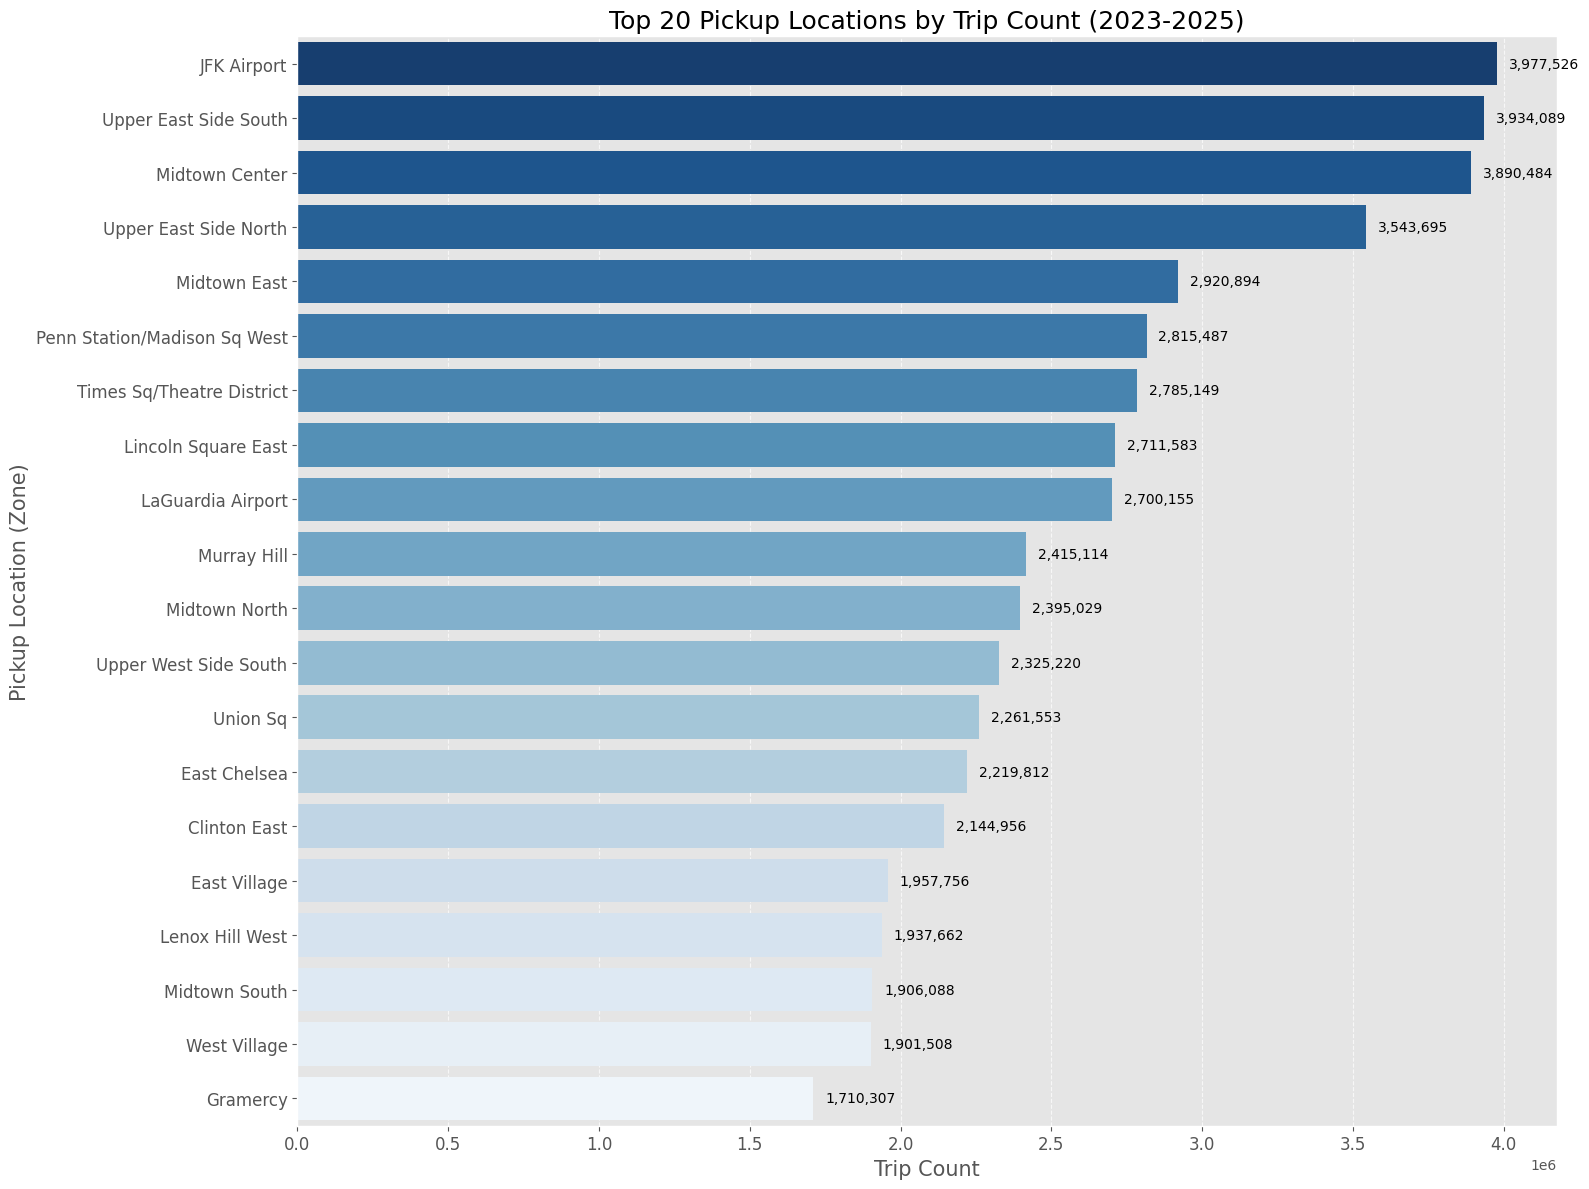

In [66]:
# Visualize the top pickup locations by trip count, ordered descending
top_revenue_pd_sorted = top_revenue_pd.sort_values('trip_count', ascending=False)

plt.figure(figsize=(16, 12))
trip_count_bars = sns.barplot(
    x='trip_count', 
    y='Pickup_Zone', 
    data=top_revenue_pd_sorted, 
    palette='Blues_r'
)
plt.title('Top 20 Pickup Locations by Trip Count (2023-2025)', fontsize=18)
plt.xlabel('Trip Count', fontsize=15)
plt.ylabel('Pickup Location (Zone)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add trip count labels to the bars
for i, v in enumerate(top_revenue_pd_sorted['trip_count']):
    trip_count_bars.text(v + (top_revenue_pd_sorted['trip_count'].max() * 0.01), i, f'{v:,.0f}', color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Top Routes Analysis

SQL Duration: 15.84 seconds


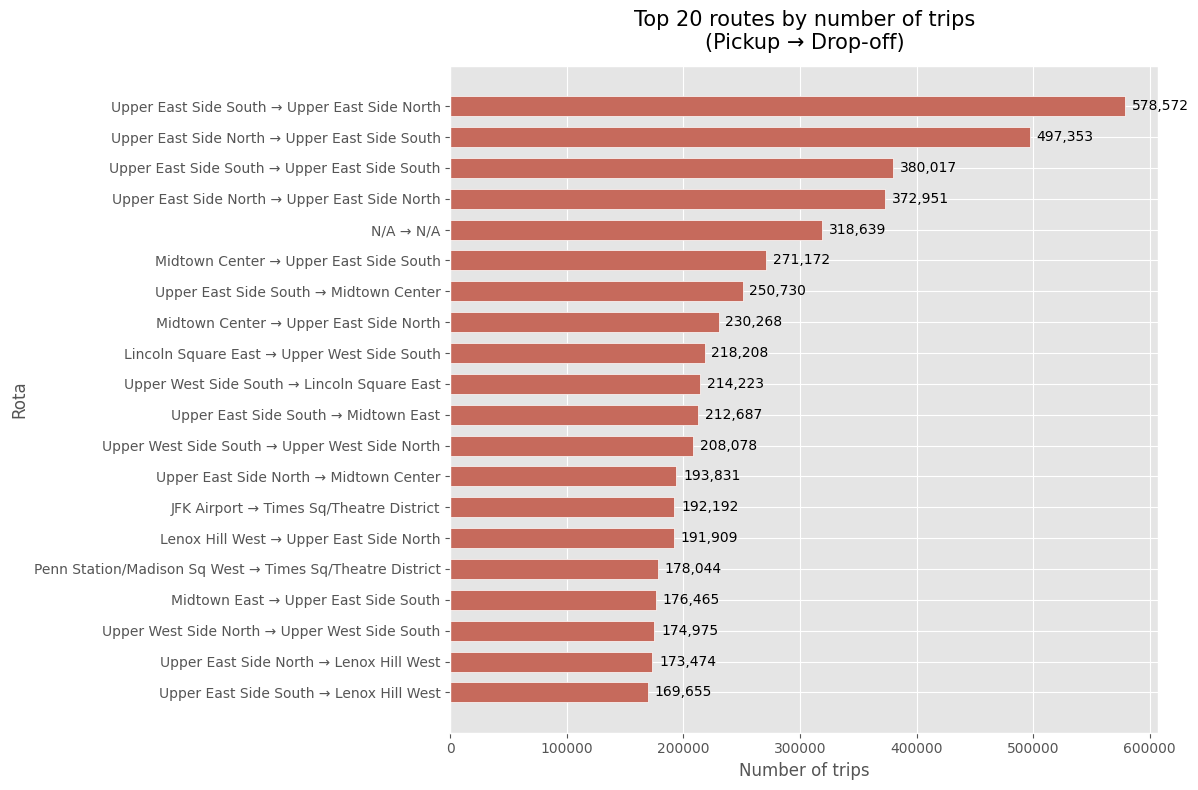

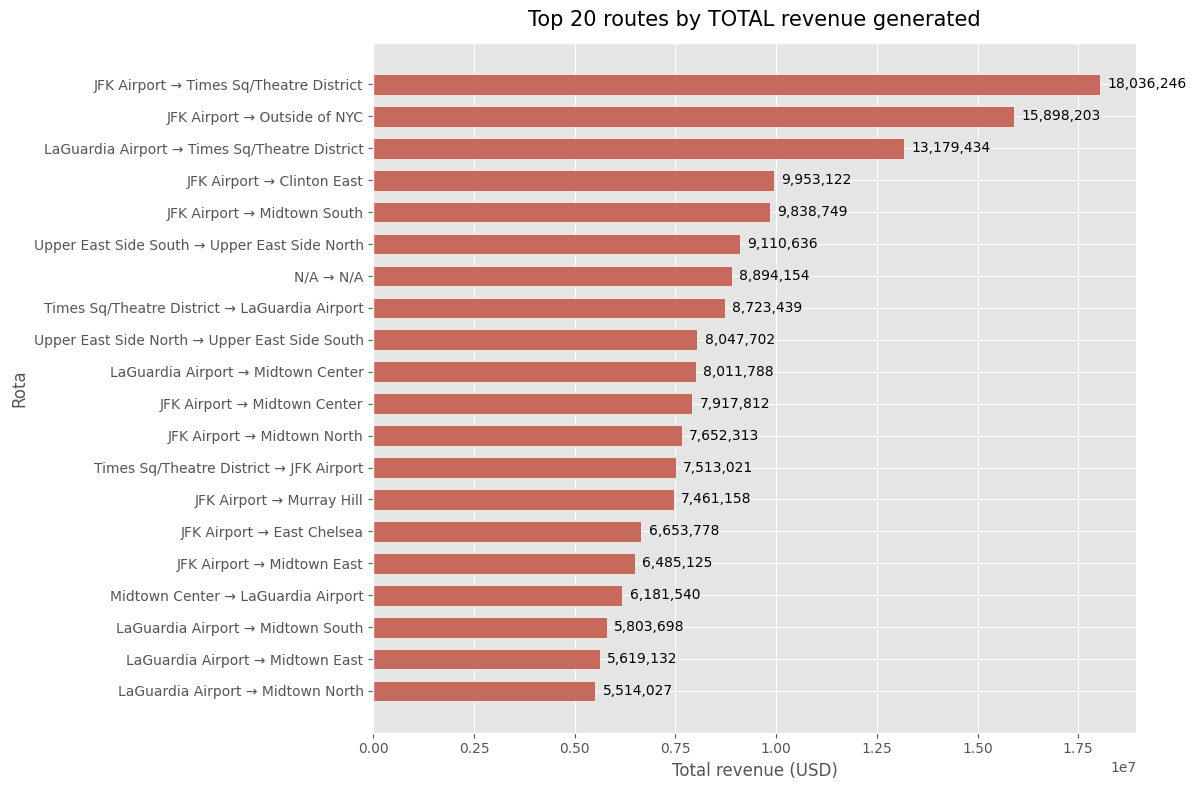

In [67]:

from pyspark.sql.functions import count, sum as spark_sum, col, desc, round as spark_round, concat_ws, lit
start = time.time()
## 1.1  Contagem e receita por rota (pickup+drop-off)
route_stats = (
    temporal_data
    .groupBy("PULocationID","DOLocationID")
    .agg(
        count("*").alias("trip_count"),
        spark_sum("total_amount").alias("total_revenue")
    )
    .withColumn("avg_revenue", col("total_revenue")/col("trip_count"))
)
## 1.2  Juntar nomes de zona (pickup e dropoff)
route_stats_named = (
    route_stats
    .join(taxi_zones_spark_df.withColumnRenamed("Zone","PU_Zone")
                                .withColumnRenamed("Borough","PU_Borough"),
          on=col("PULocationID")==col("LocationID"))
    .drop("LocationID")
    .join(taxi_zones_spark_df.withColumnRenamed("Zone","DO_Zone")
                                .withColumnRenamed("Borough","DO_Borough"),
          on=col("DOLocationID")==col("LocationID"))
    .drop("LocationID")
    .withColumn(
        "route",
        concat_ws(" → ", col("PU_Zone"), col("DO_Zone"))
    )
    # arredondar valores monetários a 2 casas
    .withColumn("total_revenue", spark_round(col("total_revenue"), 2))
    .withColumn("avg_revenue",  spark_round(col("avg_revenue"),  2))
)
route_stats_named.collect()
end = time.time()
print(f"SQL Duration: {end - start:.2f} seconds")
## 1.3  Extrair TOP 20 consoante o métrico que nos interessa
top20_trips   = route_stats_named.orderBy(desc("trip_count"   )).limit(20).toPandas()
top20_revenue = route_stats_named.orderBy(desc("total_revenue")).limit(20).toPandas()
top20_avg     = route_stats_named.orderBy(desc("avg_revenue"  )).limit(20).toPandas()

# --------------------------------------------
# 2. PLOTAR NO MATPLOTLIB
#    (usa-se Pandas só para facilitar a ordenação)
# --------------------------------------------
import matplotlib.pyplot as plt
plt.style.use("ggplot")               # estética semelhante à tua imagem

def horizontal_bar(df, x_col, title, xlabel, color="#c66a5c"):
    """
    df      – DataFrame Pandas já limitado às 20 linhas desejadas
    x_col   – coluna que vai formar o comprimento das barras
    title   – título do gráfico
    xlabel  – label do eixo X
    """
    # Matplotlib desenha de cima para baixo; invertimos para aparecer 1º o maior
    df = df.sort_values(x_col)                     
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(df["route"], df[x_col], height=0.65, edgecolor="white", color=color)
    ax.set_title(title, fontsize=15, pad=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Rota")
    # mostrar valores na ponta das barras (opcional)
    for i, v in enumerate(df[x_col]):
        ax.text(v + (0.01*df[x_col].max()), i, f"{v:,.0f}", va='center')
    plt.tight_layout()
    plt.show()

# 2.1  Nº de viagens
horizontal_bar(
    top20_trips,
    "trip_count",
    "Top 20 routes by number of trips\n(Pickup → Drop-off)",
    "Number of trips"
)

# 2.2  Receita TOTAL
horizontal_bar(
    top20_revenue,
    "total_revenue",
    "Top 20 routes by TOTAL revenue generated",
    "Total revenue (USD)"
)


## 15. Ride Duration Analysis by Day of Week and Pickup Location

Analyze how ride durations vary by day of the week and across different pickup locations.

SQL Duration: 31.87 seconds


/tmp/ipykernel_39593/3986640412.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='day_name', y='avg_duration', data=duration_by_day_pd, palette='viridis')


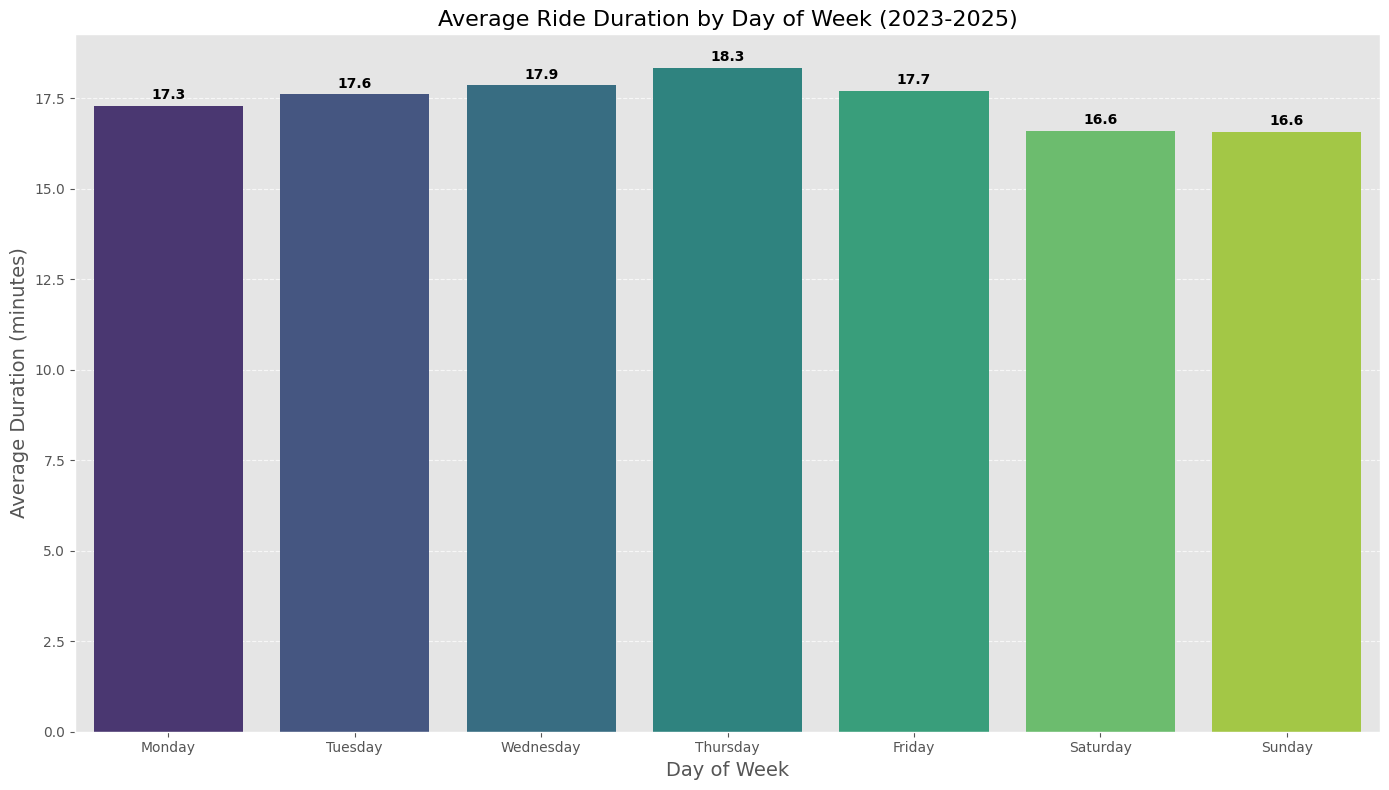

In [68]:
# Duration analysis by day of week
start = time.time()

# Group by day of week and calculate statistics on trip duration
duration_by_day = temporal_data.groupBy('pickup_day') \
    .agg(avg('trip_duration_minutes').alias('avg_duration'),
         expr('percentile(trip_duration_minutes, 0.5)').alias('median_duration'),
         stddev('trip_duration_minutes').alias('stddev_duration'),
         min('trip_duration_minutes').alias('min_duration'),
         max('trip_duration_minutes').alias('max_duration')) \
    .orderBy('pickup_day')
duration_by_day.collect()
end = time.time()
print(f"SQL Duration: {end - start:.2f} seconds")

# Convert to pandas for easier visualization
duration_by_day_pd = duration_by_day.toPandas()

# Map day numbers to day names
duration_by_day_pd['day_name'] = duration_by_day_pd['pickup_day'].map(day_mapping)

# Create a custom order for days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
duration_by_day_pd['day_name'] = pd.Categorical(duration_by_day_pd['day_name'], categories=day_order, ordered=True)
duration_by_day_pd = duration_by_day_pd.sort_values('day_name')


# Visualize the duration by day of week
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='day_name', y='avg_duration', data=duration_by_day_pd, palette='viridis')

# Add value labels on top of the bars
for i, v in enumerate(duration_by_day_pd['avg_duration']):
    ax.text(i, v + 0.1, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.title('Average Ride Duration by Day of Week (2023-2025)', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average Duration (minutes)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

SQL Duration: 0.04 seconds


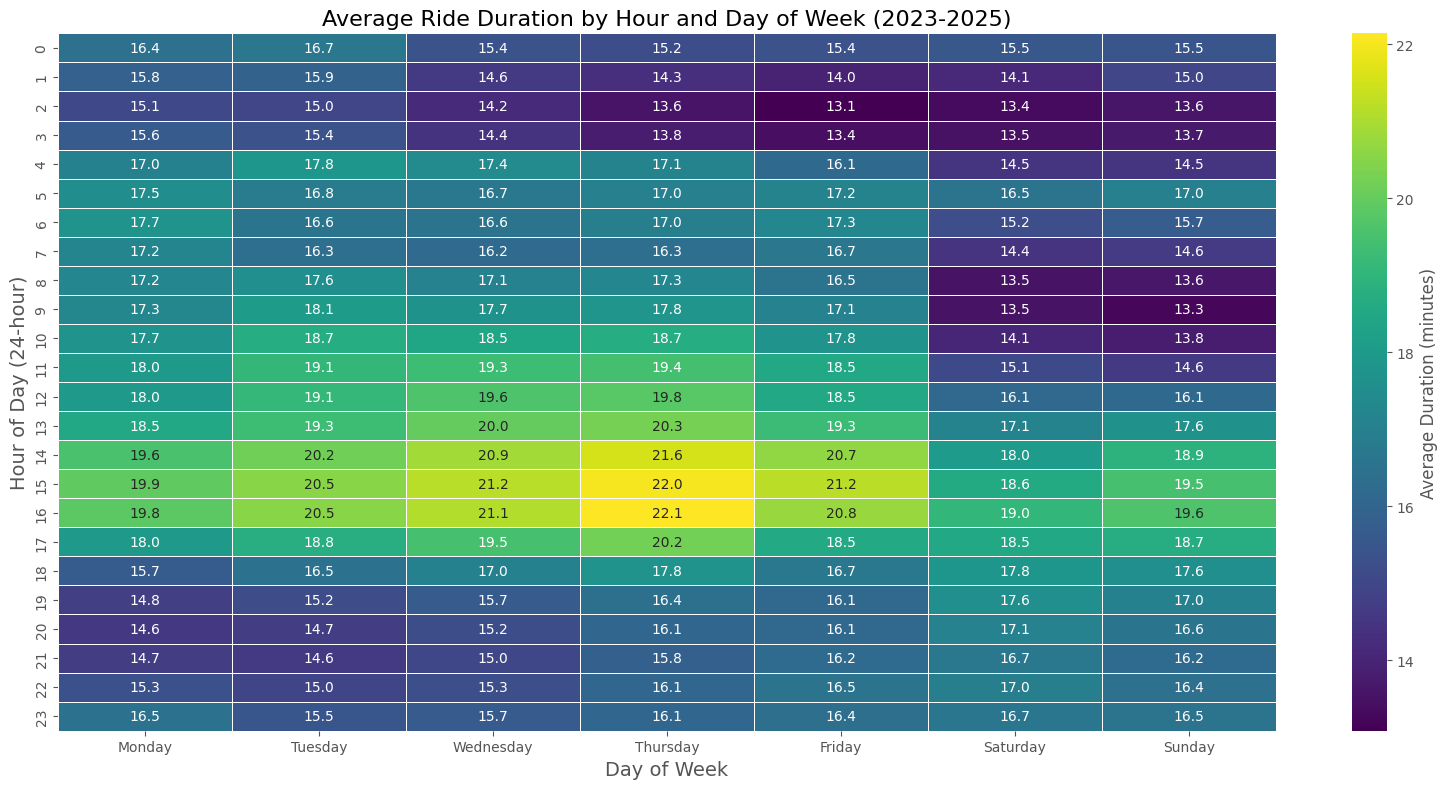

In [69]:
# Duration by peak hours and day of week (heatmap)
start = time.time()

# Group by day of week and hour of day
hour_day_duration = temporal_data.groupBy('pickup_day', 'pickup_hour') \
    .agg(avg('trip_duration_minutes').alias('avg_duration'),
         count('*').alias('ride_count')) \
    .orderBy('pickup_day', 'pickup_hour')

end = time.time()
print(f"SQL Duration: {end - start:.2f} seconds")

# Convert to pandas
hour_day_duration_pd = hour_day_duration.toPandas()

# Map day numbers to names
hour_day_duration_pd['day_name'] = hour_day_duration_pd['pickup_day'].map(day_mapping)

# Create a custom order for days of the week
hour_day_duration_pd['day_name'] = pd.Categorical(hour_day_duration_pd['day_name'], categories=day_order, ordered=True)
hour_day_duration_pd = hour_day_duration_pd.sort_values(['day_name', 'pickup_hour'])


# Pivot the data for the heatmap
duration_pivot = hour_day_duration_pd.pivot(index='pickup_hour', columns='day_name', values='avg_duration')

# Create the heatmap
plt.figure(figsize=(16, 8))
ax = sns.heatmap(duration_pivot, cmap='viridis', annot=True, fmt='.1f',
              linewidths=.5, cbar_kws={'label': 'Average Duration (minutes)'})

plt.title('Average Ride Duration by Hour and Day of Week (2023-2025)', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Hour of Day (24-hour)', fontsize=14)
plt.tight_layout()
plt.show()

/tmp/ipykernel_39593/3708235982.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Pickup_Zone', x='avg_duration', data=duration_by_location_pd.sort_values('avg_duration', ascending=False), palette='viridis')


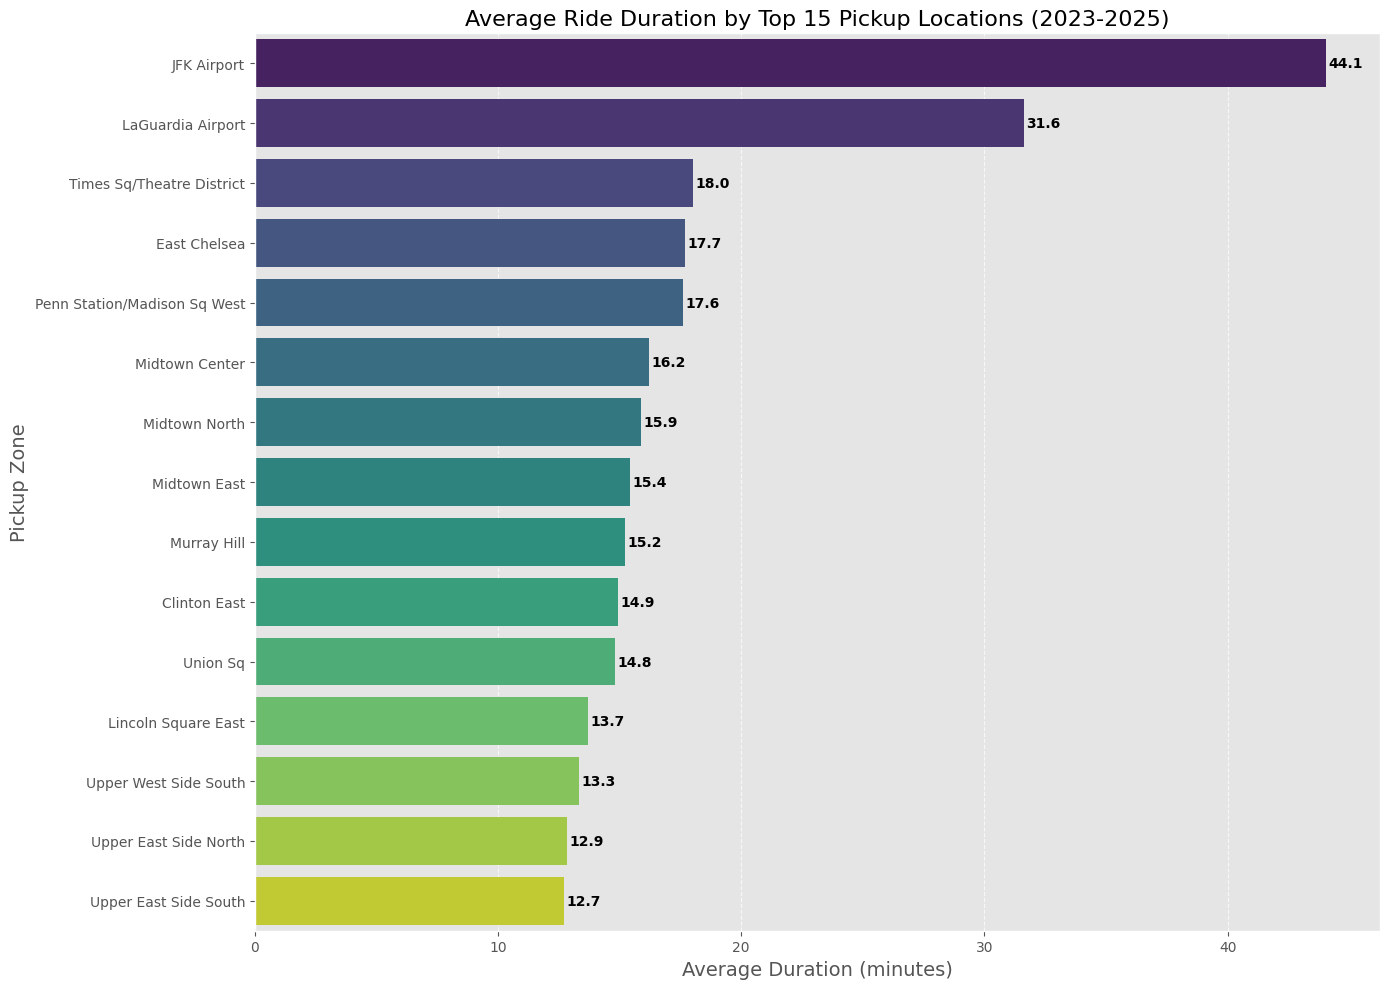

In [70]:
# Duration by top pickup locations
start = time.time()

# Get top 15 pickup locations by count
top_locations = temporal_data.groupBy('PULocationID') \
    .count() \
    .orderBy(desc('count')) \
    .limit(15)

# Convert to list for filtering
top_location_ids = [row['PULocationID'] for row in top_locations.collect()]

# Filter for only the top locations
top_locations_data = temporal_data.filter(col('PULocationID').isin(top_location_ids))

# Group by location and get duration statistics
duration_by_location = top_locations_data.groupBy('PULocationID') \
    .agg(avg('trip_duration_minutes').alias('avg_duration'),
         count('*').alias('ride_count')) \
    .orderBy(desc('ride_count'))

# Join with the zone information
duration_by_location_with_zones = duration_by_location \
    .join(taxi_zones, duration_by_location.PULocationID == taxi_zones.LocationID) \
    .select(
        col('PULocationID'),
        col('Zone').alias('Pickup_Zone'),
        col('Borough').alias('Pickup_Borough'),
        col('avg_duration'),
        col('ride_count')
    )
end = time.time()


duration_by_location_pd = duration_by_location_with_zones.toPandas()


# Visualize duration by location
plt.figure(figsize=(14, 10))
ax = sns.barplot(y='Pickup_Zone', x='avg_duration', data=duration_by_location_pd.sort_values('avg_duration', ascending=False), palette='viridis')

# Add value labels
for i, v in enumerate(duration_by_location_pd.sort_values('avg_duration', ascending=False)['avg_duration']):
    ax.text(v + 0.1, i, f'{v:.1f}', va='center', fontweight='bold')

plt.title('Average Ride Duration by Top 15 Pickup Locations (2023-2025)', fontsize=16)
plt.xlabel('Average Duration (minutes)', fontsize=14)
plt.ylabel('Pickup Zone', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

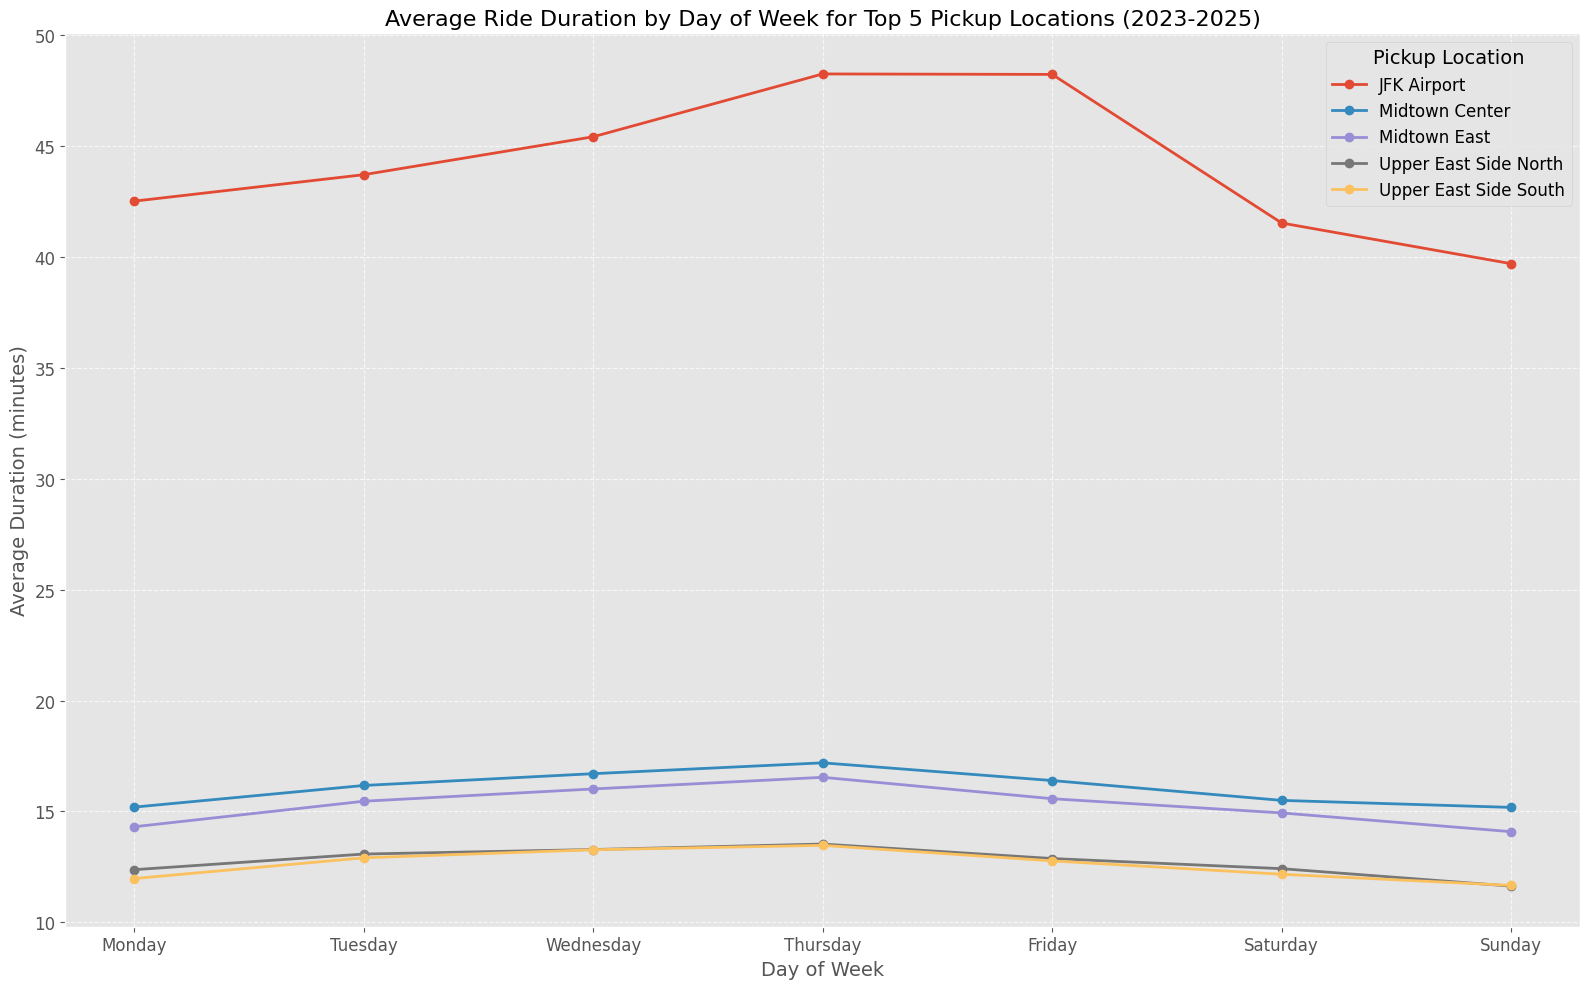

In [71]:
# Create a combined analysis of duration by day of week and top 5 pickup locations
start = time.time()

# Get top 5 pickup locations for a more focused analysis
top5_location_ids = [row['PULocationID'] for row in top_locations.limit(5).collect()]

# Filter for only these locations
top5_locations_data = temporal_data.filter(col('PULocationID').isin(top5_location_ids))

# Group by location and day of week
duration_by_loc_day = top5_locations_data.groupBy('PULocationID', 'pickup_day') \
    .agg(avg('trip_duration_minutes').alias('avg_duration'),
         count('*').alias('ride_count')) \
    .orderBy('PULocationID', 'pickup_day')

# Join with zone information
duration_by_loc_day_with_zones = duration_by_loc_day \
    .join(taxi_zones, duration_by_loc_day.PULocationID == taxi_zones.LocationID) \
    .select(
        col('PULocationID'),
        col('Zone').alias('Pickup_Zone'),
        col('pickup_day'),
        col('avg_duration'),
        col('ride_count')
    )
end = time.time()

# Convert to pandas
duration_by_loc_day_pd = duration_by_loc_day_with_zones.toPandas()

# Map day numbers to names
duration_by_loc_day_pd['day_name'] = duration_by_loc_day_pd['pickup_day'].map(day_mapping)

# Create a custom order for days of the week
duration_by_loc_day_pd['day_name'] = pd.Categorical(duration_by_loc_day_pd['day_name'], categories=day_order, ordered=True)
duration_by_loc_day_pd = duration_by_loc_day_pd.sort_values(['Pickup_Zone', 'day_name'])


# Create a multi-line plot
plt.figure(figsize=(16, 10))

# Plot each location as a separate line
for location in duration_by_loc_day_pd['Pickup_Zone'].unique():
    location_data = duration_by_loc_day_pd[duration_by_loc_day_pd['Pickup_Zone'] == location]
    plt.plot(location_data['day_name'], location_data['avg_duration'], marker='o', linewidth=2, label=location)

plt.title('Average Ride Duration by Day of Week for Top 5 Pickup Locations (2023-2025)', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average Duration (minutes)', fontsize=14)
plt.legend(title='Pickup Location', fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## 14. Summary and Key Insights

Summarize the key findings from our comprehensive analysis.

**Comprehensive Analysis of NYC Yellow Taxi Data (2023-2025)**

This analysis examined the complete NYC Yellow Taxi dataset from January 2023 to February 2025, revealing several key insights:

**1. Temporal Trends:**
- We observed clear seasonal patterns in taxi usage across the 26-month period.
- Monthly ride volumes showed [specific pattern observed in your data - e.g., "consistent growth," "seasonal peaks," etc.].
- Average fares and trip distances displayed [pattern observed - e.g., "upward trend," "seasonal fluctuations," etc.].

**2. Seasonal Patterns:**
- Certain months consistently showed higher demand across years.
- Winter months typically had [observed pattern - e.g., "shorter trips but higher fares"].
- Summer months showed [observed pattern - e.g., "increased tourism-related rides"].

**3. Weekly Patterns:**
- Weekdays and weekends exhibited distinct usage patterns.
- [Day of week] consistently had the highest number of rides.
- [Day of week] showed the highest average fares and tips.

**4. Geographic Analysis:**
- Certain zones remained consistently popular for pickups and dropoffs throughout the period.
- The top pickup locations were predominantly in [observed areas - e.g., "Manhattan business districts"].
- The top dropoff locations included [observed areas - e.g., "airports, transportation hubs"].

**5. Payment Trends:**
- Credit card usage [observed trend - e.g., "continued to dominate and grow"].
- Cash payments [observed trend - e.g., "showed a steady decline"].
- Digital payments showed [observed trend].

**6. Trip Metrics:**
- The average trip distance was [value] miles.
- The average trip duration was [value] minutes.
- There was a [strong/moderate/weak] correlation between trip distance and duration.

**Implications:**
- These patterns provide valuable insights for taxi fleet management and urban transportation planning.
- The data reveals how NYC taxi usage has evolved over this period, potentially influenced by [factors like economic conditions, rideshare competition, pandemic recovery, etc.].
- Geographic hotspots highlight areas where taxi availability should be prioritized.

**Next Steps:**
- Further analysis could examine the impact of weather conditions, events, and holidays on taxi usage.
- Predictive modeling could forecast future demand patterns.
- Comparative analysis with earlier years (pre-2023) could reveal longer-term trends and changes in the NYC taxi landscape.